安装爬虫数据依赖

In [ ]:
!pip install alpha_vantage praw
import yfinance as yf
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import tweepy
import praw
import numpy as np
import requests
import pandas as pd
from datetime import datetime, timedelta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 10.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Get Financial Data

In [ ]:
symbol = 'ETH'
# Yahoo Finance
def get_financial_data_yahoo(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    hist.reset_index(inplace=True)
    hist['Date'] = pd.to_datetime(hist['Hour']).dt.date
    return hist
yahoo_data = get_financial_data_yahoo(symbol + '-USD')
print("Yahoo Finance Data:")
print(yahoo_data)
print(f"Number of rows in Yahoo Finance Data: {len(yahoo_data)}")

Get Market Data

In [ ]:
import requests
import pandas as pd
import datetime
from requests.auth import HTTPBasicAuth

# Reddit API 配置信息
REDDIT_CLIENT_ID = "9DU_ymjT_rLiaLSG62uG2Q"
REDDIT_CLIENT_SECRET = "tZWjN2mq-a-2YtO6-AR3FIPcI7MEhQ"
REDDIT_USER_AGENT = "multimodel-blockchain-analysis/0.1 by /u/Worried_Caregiver488"

# 获取访问令牌
def get_access_token():
    auth = HTTPBasicAuth(REDDIT_CLIENT_ID, REDDIT_CLIENT_SECRET)
    data = {"grant_type": "client_credentials"}
    headers = {"User-Agent": REDDIT_USER_AGENT}

    response = requests.post("https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to get access token: {response.status_code} - {response.text}")

    token = response.json().get("access_token")
    if not token:
        raise Exception("Failed to retrieve access token")

    return token

# 获取 Reddit 数据
def get_reddit_data(subreddit, query, start_time, end_time, max_results=1000):
    access_token = get_access_token()
    headers = {
        "Authorization": f"bearer {access_token}",
        "User-Agent": REDDIT_USER_AGENT
    }

    base_url = f"https://oauth.reddit.com/r/{subreddit}/search"
    params = {
        "q": query,
        "limit": 100,
        "sort": "new",
        "restrict_sr": 1,
        "after": start_time,
        "before": end_time
    }

    data = []
    while len(data) < max_results:
        response = requests.get(base_url, headers=headers, params=params)

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code} - {response.text}")
            break

        results = response.json()
        posts = results.get("data", {}).get("children", [])

        if not posts:
            print("No more posts returned")
            break

        for post in posts:
            post_data = post["data"]
            post_dict = {
                "title": post_data["title"],
                "content": post_data.get("selftext", ""),
                "time": datetime.datetime.fromtimestamp(post_data["created_utc"]),
                "upvotes": post_data["score"],
                "num_comments": post_data["num_comments"]
            }
            data.append(post_dict)

        # 使用 'after' 进行分页请求
        params["after"] = results.get("data", {}).get("after")
        if not params["after"]:
            break

    return pd.DataFrame(data)

# 测试最近一年的数据
subreddit = "CryptoCurrency"
query = "ETH"
end_time = int(datetime.datetime.now().timestamp())
start_time = int((datetime.datetime.now() - datetime.timedelta(days=365)).timestamp())

reddit_df = get_reddit_data(subreddit, query, start_time, end_time)

print("Reddit Data:")
print(reddit_df)
print(f"Number of rows in Reddit Data: {len(reddit_df)}")


Get Transaction Data

In [ ]:
import requests
import pandas as pd

def get_cryptocompare_data(fsym, tsym, limit):
    """
    从CryptoCompare API获取加密货币的历史数据，并将其作为DataFrame返回。

    参数：
    fsym (str): 加密货币的符号（例如 'ETH' 表示以太坊）。
    tsym (str): 转换的目标货币符号（例如 'USD' 表示美元）。
    limit (int): 要获取的历史数据的天数。

    返回：
    DataFrame: 包含历史数据的pandas DataFrame。
    """
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    parameters = {
        'fsym': fsym,  # 加密货币符号
        'tsym': tsym,  # 目标货币符号
        'limit': limit,  # 要请求的数据天数
        'api_key': '4c288dcdc61dd9e38e99180f6baf717f72fc9140fdf0592bb03ba7d8c6e523de'  # API密钥
    }

    # 发送GET请求到CryptoCompare API
    response = requests.get(url, params=parameters)
    data = response.json()  # 解析返回的JSON数据

    if response.status_code == 200 and data['Response'] == 'Success':
        # 请求成功，提取数据并转换为DataFrame
        df = pd.DataFrame(data['Data']['Data'])
        # 将时间戳转换为日期时间格式，方便后续操作
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        # 请求失败，打印错误信息
        print("获取数据失败:", data.get('Message', '没有提供错误信息'))
        return pd.DataFrame()

# 使用该函数获取数据
cryptocompare_data = get_cryptocompare_data('ETH', 'USD', 365)

# 输出获取的数据
print("CryptoCompare 数据:")
print(cryptocompare_data)
print(f"CryptoCompare 数据的行数: {len(cryptocompare_data)}")


Price Action Preprocessing

Mounted at /content/drive


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 24, 64)              │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 6, 100)              │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,777 (585.07 KB)

 Trainable params: 149,393 (583.57 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2107

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 1.1258 - val_loss: 0.8115
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6238

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6236 - val_loss: 0.7552
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5814

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5804 - val_loss: 0.6200
Epoch 4/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5610

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5576 - val_loss: 0.5718
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5100

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5106 - val_loss: 0.5644
Epoch 6/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5153

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5156 - val_loss: 0.5457
Epoch 7/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4786

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4803 - val_loss: 0.4647
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.4562 - val_loss: 0.4965
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4435

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4433 - val_loss: 0.4027
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4642 - val_loss: 0.4248
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.4271 - val_loss: 0.4182
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4262

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.4270 - val_loss: 0.3712
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4523 - val_loss: 0.3834
Epoch 14/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3902

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3918 - val_loss: 0.3421
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3751 - val_loss: 0.3429
Epoch 16/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3661

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3665 - val_loss: 0.3274
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3589 - val_loss: 0.3575
Epoch 18/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3679

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3692 - val_loss: 0.3253
Epoch 19/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3469

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3476 - val_loss: 0.3108
Epoch 20/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3515 - val_loss: 0.3119
Epoch 21/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3316

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3326 - val_loss: 0.2858
Epoch 22/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3185

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3186 - val_loss: 0.2733
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3040 - val_loss: 0.2741
Epoch 24/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2932

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2941 - val_loss: 0.2548
Epoch 25/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3033 - val_loss: 0.2953
Epoch 26/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2925 - val_loss: 0.2644
Epoch 27/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2795

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2796 - val_loss: 0.2490
Epoch 28/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2824

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2832 - val_loss: 0.2374
Epoch 29/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2729

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2743 - val_loss: 0.2317
Epoch 30/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2651 - val_loss: 0.2366
Epoch 31/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2493

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2498 - val_loss: 0.2149
Epoch 32/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2534 - val_loss: 0.2204
Epoch 33/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2435

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2437 - val_loss: 0.2123
Epoch 34/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2526

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2534 - val_loss: 0.2099
Epoch 35/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2502 - val_loss: 0.2403
Epoch 36/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2510

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2483 - val_loss: 0.1986
Epoch 37/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2170 - val_loss: 0.2086
Epoch 38/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2256

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2262 - val_loss: 0.1841
Epoch 39/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2212 - val_loss: 0.1960
Epoch 40/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2230 - val_loss: 0.1857
Epoch 41/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2144

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2155 - val_loss: 0.1804
Epoch 42/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2246

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2217 - val_loss: 0.1761
Epoch 43/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2000 - val_loss: 0.1817
Epoch 44/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2012

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2010 - val_loss: 0.1607
Epoch 45/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1921 - val_loss: 0.1809
Epoch 46/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2030

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2028 - val_loss: 0.1551
Epoch 47/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1949 - val_loss: 0.1662
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1885 - val_loss: 0.1577
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1833 - val_loss: 0.1592
Epoch 50/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1907

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1876 - val_loss: 0.1501


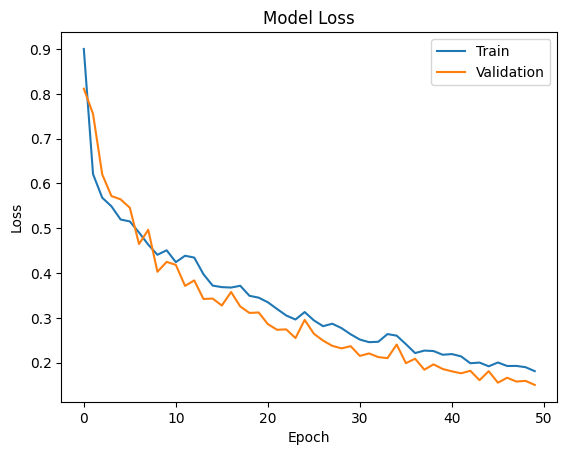

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from google.colab import drive

def mount_drive():
    """挂载Google Drive"""
    drive.mount('/content/drive')

def price_action_preprocess_data(file_path):
    """预处理价格行为数据"""
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'MACD_signal', 'MACD_hist', 'slowk', 'slowd']
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    X = df[features].values
    y = df['Close'].values

    num_samples = (len(X) // 24) * 24
    X = X[:num_samples].reshape(-1, 24, len(features))
    y = y[:num_samples].reshape(-1, 24)[:, -1]

    return X, y

def price_action_model(input_shape):
    """构建价格行为模型，并提取特征"""
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = LSTM(50, return_sequences=False, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    features = Dense(10, activation='relu', kernel_regularizer=l2(0.001), name='feature_layer')(x)
    outputs = Dense(1, kernel_regularizer=l2(0.001))(features)

    full_model = Model(inputs, outputs)
    feature_model = Model(inputs, features)
    full_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return full_model, feature_model

def train_model(full_model, X_train, y_train, X_val, y_val):
    """训练模型"""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_pa_model.h5', monitor='val_loss', save_best_only=True)
    ]

    history = full_model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=50, batch_size=32, callbacks=callbacks
    )

    return history

def plot_loss(history):
    """绘制训练和验证损失曲线"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

def save_features(feature_model, X_train, X_val):
    """提取并保存特征"""
    train_features = feature_model.predict(X_train)
    val_features = feature_model.predict(X_val)

    np.save('/content/drive/My Drive/pa_features_train.npy', train_features)
    np.save('/content/drive/My Drive/pa_features_val.npy', val_features)

def main():
    mount_drive()
    file_path = '/content/drive/My Drive/bimodel_dataset.csv'

    X_price, y_price = price_action_preprocess_data(file_path)
    input_shape = (24, 10)

    full_model_price, feature_model_price = price_action_model(input_shape)
    full_model_price.summary()

    X_train, X_val, y_train, y_val = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

    history = train_model(full_model_price, X_train, y_train, X_val, y_val)
    plot_loss(history)

    save_features(feature_model_price, X_train, X_val)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 24, 32)              │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,389 (149.96 KB)

 Trainable params: 38,325 (149.71 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4998

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.4899 - val_loss: 0.2856 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1489

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1468 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 3/100
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0911

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0964 - val_loss: 0.1222 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0630

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0639 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0564

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0562 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0593

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0590 - val_loss: 0.0745 - learning_rate: 0.0010
Epoch 7/100
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0537

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0510 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0539 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0351 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 10/100
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0281 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0333 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0380 - val_loss: 0.0758 - learning_rate: 0.0010
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0452

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0452 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0410

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0412 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0472 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 15/100
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0477

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0443 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0379 - val_loss: 0.0617 - learning_rate: 0.0010
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0340 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0557 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0456 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0538 - val_loss: 0.0451 - learning_rate: 5.0000e-04


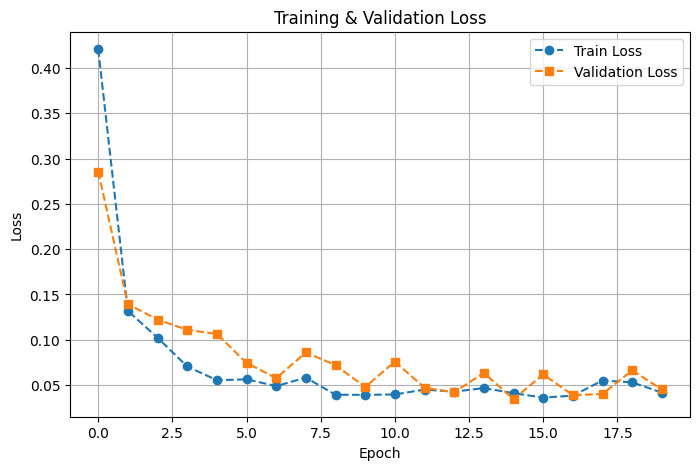

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

# 数据预处理函数
def price_action_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'MACD_signal', 'MACD_hist', 'slowk', 'slowd']
    scaler = StandardScaler()

    df_train = df.iloc[:int(len(df) * 0.8)]
    scaler.fit(df_train[features])  # 仅在训练集上 fit
    df[features] = scaler.transform(df[features])

    num_samples = (len(df) // 24) * 24  # 确保数据样本数是 24 的倍数
    X = df[features].values[:num_samples].reshape(-1, 24, len(features))
    y = df['Close'].values[:num_samples].reshape(-1, 24)[:, -1]  # 预测最后一个时间步的收盘价

    return X, y

# 模型构建函数
def price_action_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=32, kernel_size=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)  # 保持时间维度

    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    features = Dense(10, activation='relu', name='feature_layer')(x)
    outputs = Dense(1)(features)

    full_model = Model(inputs, outputs)
    feature_model = Model(inputs, features)
    full_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return full_model, feature_model

# 预处理数据
price_action_file_path = '/content/drive/My Drive/bimodel_dataset.csv'
X_price, y_price = price_action_preprocess_data(price_action_file_path)
input_shape_price = (24, 10)

# 构建模型
full_model_price, feature_model_price = price_action_model(input_shape_price)
full_model_price.summary()

# 拆分训练集和验证集
X_price_train, X_price_val, y_price_train, y_price_val = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# 训练模型
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/best_pa_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = full_model_price.fit(X_price_train, y_price_train, validation_data=(X_price_val, y_price_val),
                               epochs=100, batch_size=64, callbacks=callbacks)

# 绘制损失曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o', linestyle='dashed')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', linestyle='dashed')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 提取并保存特征
price_features_train = feature_model_price.predict(X_price_train, batch_size=64)
price_features_val = feature_model_price.predict(X_price_val, batch_size=64)

np.save('/content/drive/My Drive/pa_features_train.npy', price_features_train)
np.save('/content/drive/My Drive/pa_features_val.npy', price_features_val)


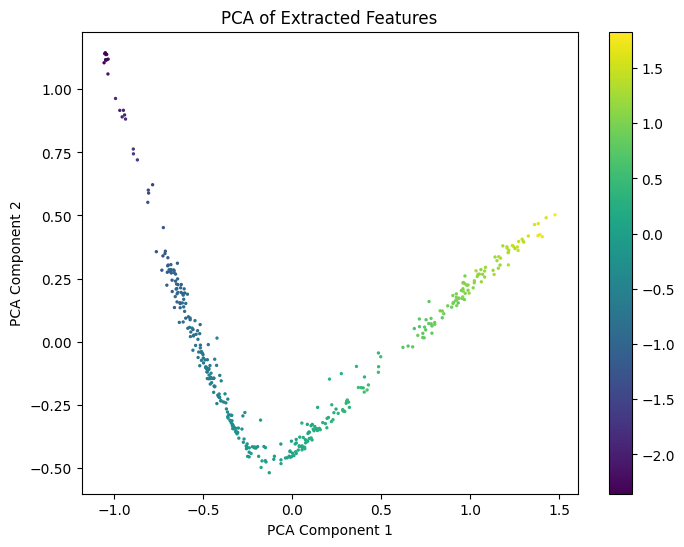

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


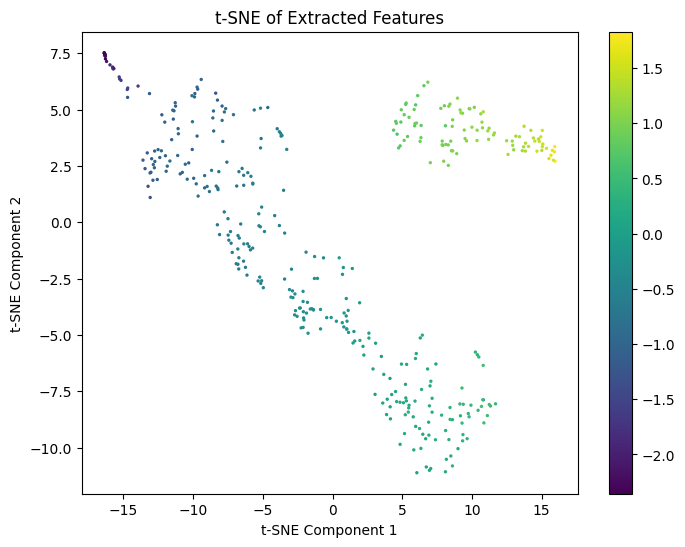

Train MSE: 0.0051545981694542916
Validation MSE: 0.00527676812863248


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 加载保存的特征数据
price_features_train = np.load('/content/drive/My Drive/pa_features_train.npy')
price_features_val = np.load('/content/drive/My Drive/pa_features_val.npy')

# PCA 可视化
pca = PCA(n_components=2)  # 使用PCA将特征降至2维
pca_result = pca.fit_transform(price_features_train)  # 将训练集特征降维

# 绘制PCA降维后的数据分布
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_price_train, cmap='viridis', s=2)  # 使用训练集目标值y_price_train进行颜色映射
plt.title('PCA of Extracted Features')  # 设置标题
plt.xlabel('PCA Component 1')  # 设置x轴标签
plt.ylabel('PCA Component 2')  # 设置y轴标签
plt.colorbar()  # 显示颜色条
plt.show()  # 显示图像

# t-SNE 可视化
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # 使用t-SNE进行降维
tsne_result = tsne.fit_transform(price_features_train)  # 将训练集特征降维

# 绘制t-SNE降维后的数据分布
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_price_train, cmap='viridis', s=2)  # 使用训练集目标值y_price_train进行颜色映射
plt.title('t-SNE of Extracted Features')  # 设置标题
plt.xlabel('t-SNE Component 1')  # 设置x轴标签
plt.ylabel('t-SNE Component 2')  # 设置y轴标签
plt.colorbar()  # 显示颜色条
plt.show()  # 显示图像

# 使用简单模型（线性回归）评估特征
# 训练线性回归模型
lr = LinearRegression()
lr.fit(price_features_train, y_price_train)  # 使用训练集特征和目标值训练模型

# 对训练集和验证集进行预测
y_pred_train = lr.predict(price_features_train)  # 预测训练集
y_pred_val = lr.predict(price_features_val)  # 预测验证集

# 评估模型性能
train_mse = mean_squared_error(y_price_train, y_pred_train)  # 计算训练集的均方误差
val_mse = mean_squared_error(y_price_val, y_pred_val)  # 计算验证集的均方误差

# 输出训练集和验证集的均方误差
print(f'Train MSE: {train_mse}')
print(f'Validation MSE: {val_mse}')


Market Sentiment Prerpocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install vaderSentiment transformers

import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 下载 NLTK 数据
nltk.download('stopwords')
nltk.download('wordnet')

# 初始化情感分析模型
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
vader_analyzer = SentimentIntensityAnalyzer()
print("情感分析器已初始化")

# 文本预处理函数
def preprocess_text(text):
    try:
        # 去除URL
        text = re.sub(r"http\S+", "", text)
        # 转换为小写
        text = text.lower()
        # 去除标点符号
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # 去除数字
        text = re.sub(r"\d+", "", text)
        # 去除停用词
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        # 词形还原
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        # 重新连接单词为一个字符串
        return " ".join(words)
    except Exception as e:
        print(f"预处理文本时出错: {e}")
        return ""

# 截断长文本
def truncate_text(text, max_length=512):
    words = text.split()
    if len(words) > max_length:
        return " ".join(words[:max_length])
    return text

# 带缓存的情感分析函数，提高性能
def cached_sentiment_analysis(text, model_cache, analyzer):
    if text in model_cache:
        return model_cache[text]
    try:
        sentiment = analyzer(text)[0]['label']
        model_cache[text] = sentiment
        return sentiment
    except Exception as e:
        print(f"情感分析时出错: {e}")
        return None

# 预处理情感数据函数
def preprocess_sentiment_data(file_path):
    print("加载数据...")
    df = pd.read_csv(file_path)
    print("数据加载完成")

    # 清理数据
    df.dropna(subset=['title', 'text'], inplace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)
    df.set_index('date', inplace=True)

    print("截断文本...")
    df['title'] = df['title'].apply(truncate_text)
    df['text'] = df['text'].apply(truncate_text)

    print("预处理文本...")
    df['title'] = df['title'].apply(preprocess_text)
    df['text'] = df['text'].apply(preprocess_text)

    # 使用缓存进行情感分析
    bert_cache = {}
    print("进行情感分析...")
    df['bert_sentiment_title'] = df['title'].apply(lambda x: cached_sentiment_analysis(x, bert_cache, sentiment_model))
    df['vader_sentiment_title'] = df['title'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
    df['bert_sentiment_text'] = df['text'].apply(lambda x: cached_sentiment_analysis(x, bert_cache, sentiment_model))
    df['vader_sentiment_text'] = df['text'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

    print("将BERT标签转换为数值...")
    df['bert_sentiment_title'] = df['bert_sentiment_title'].map({'NEGATIVE': -1, 'POSITIVE': 1})
    df['bert_sentiment_text'] = df['bert_sentiment_text'].map({'NEGATIVE': -1, 'POSITIVE': 1})

    print("确保情感分数为数值类型...")
    sentiment_columns = ['vader_sentiment_title', 'vader_sentiment_text', 'bert_sentiment_title', 'bert_sentiment_text']
    df[sentiment_columns] = df[sentiment_columns].apply(pd.to_numeric, errors='coerce')

    print("按小时重新采样数据...")
    df_resampled = df[sentiment_columns].resample('H').mean()
    df_resampled.fillna(method='ffill', inplace=True)

    print("标准化数据...")
    scaler = StandardScaler()
    df_resampled[sentiment_columns] = scaler.fit_transform(df_resampled[sentiment_columns])

    return df_resampled




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


情感分析器已初始化


In [ ]:
# 加载并预处理情感数据
file_path = '/content/drive/My Drive/btc_sentiment.csv'
processed_df = preprocess_sentiment_data(file_path)
print(processed_df)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


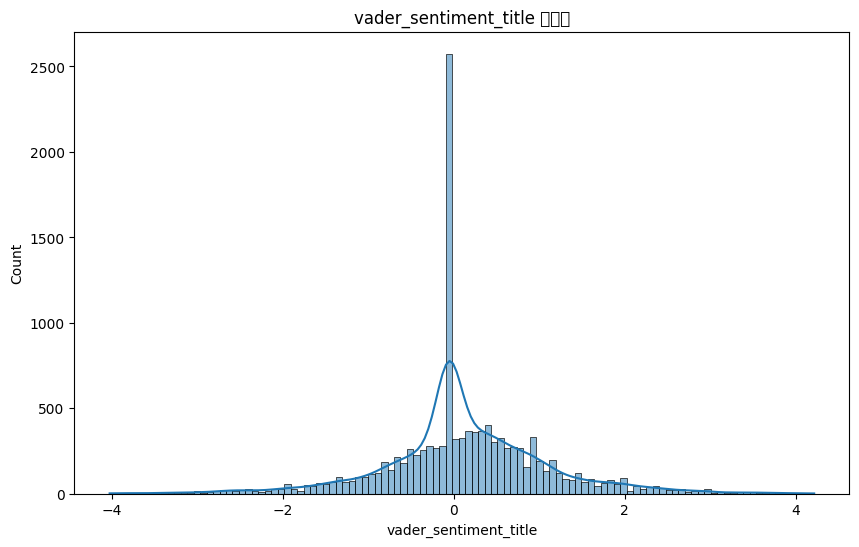

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


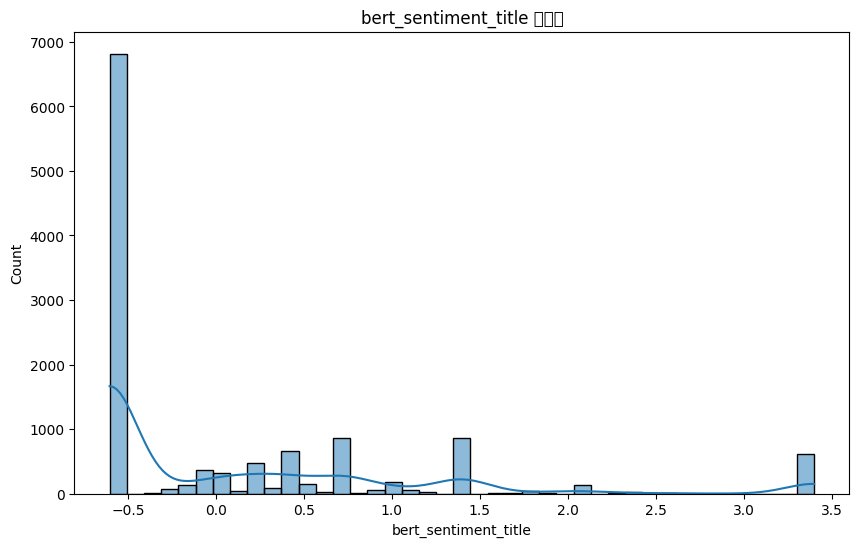

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


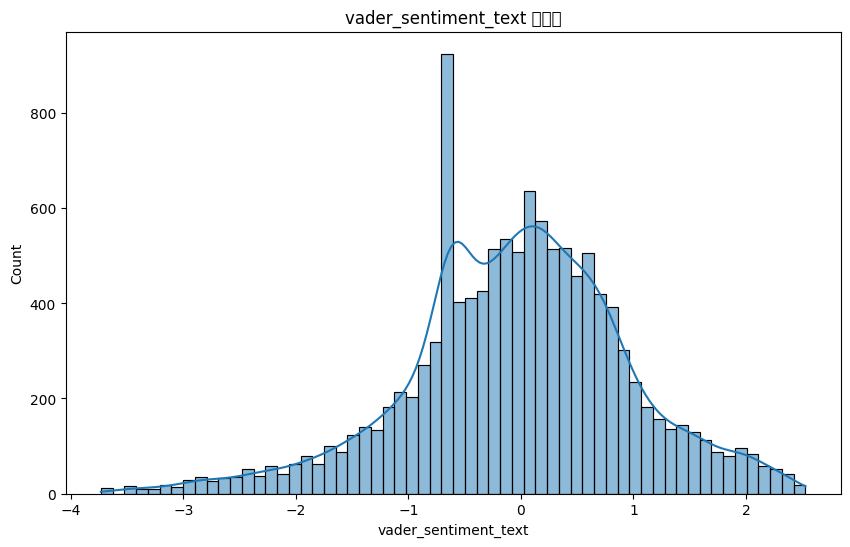

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


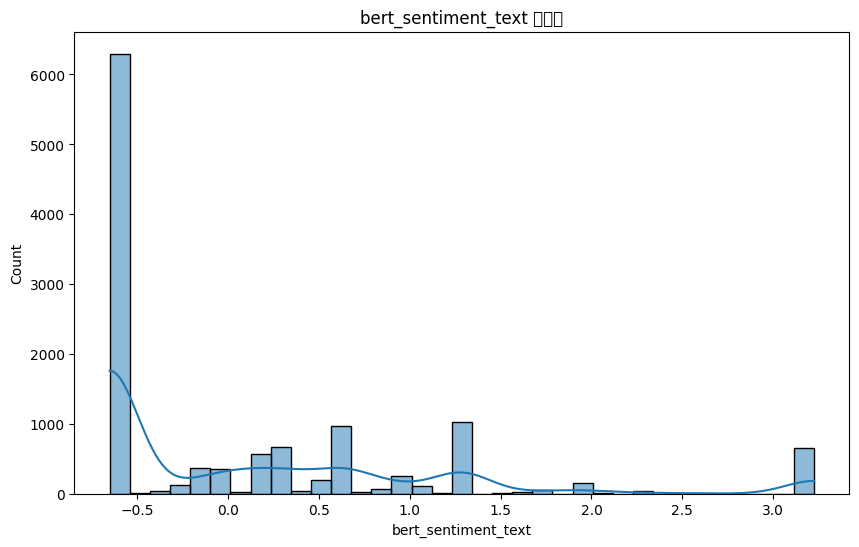

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  fig.canvas

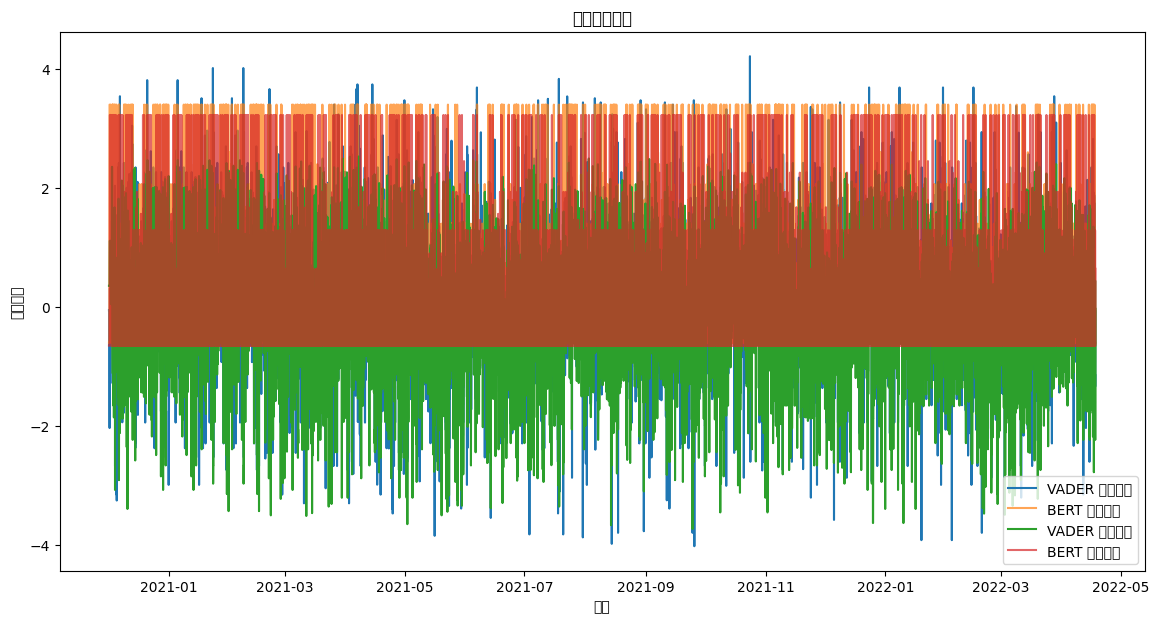

In [8]:
!pip install mplfinance

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据集
processed_df = pd.read_csv('/content/drive/My Drive/bimodel_dataset.csv', index_col=0)
processed_df.index = pd.to_datetime(processed_df.index)  # 将第一列转换为日期时间格式，并设置为索引

# 可视化数据分布的函数
def visualize_data_distribution(df, column):
    """
    可视化指定列的数据分布，使用直方图和核密度估计图。

    参数：
    - df：数据集
    - column：需要可视化的列名
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)  # 绘制直方图并显示核密度估计
    plt.title(f'{column} 的分布')  # 设置标题
    plt.show()

# 可视化情感时间序列的函数
def visualize_sentiment_timeseries(df):
    """
    可视化情感分数随时间的变化，包括VADER和BERT情感分析的标题和文本分数。

    参数：
    - df：数据集
    """
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['vader_sentiment_title'], label='VADER 情感标题')
    plt.plot(df.index, df['bert_sentiment_title'], label='BERT 情感标题', alpha=0.7)
    plt.plot(df.index, df['vader_sentiment_text'], label='VADER 情感文本')
    plt.plot(df.index, df['bert_sentiment_text'], label='BERT 情感文本', alpha=0.7)
    plt.title('情感时间序列')  # 设置标题
    plt.xlabel('时间')  # x轴标签
    plt.ylabel('情感分数')  # y轴标签
    plt.legend()  # 显示图例
    plt.show()

# 可视化情感分数的分布
visualize_data_distribution(processed_df, 'vader_sentiment_title')
visualize_data_distribution(processed_df, 'bert_sentiment_title')
visualize_data_distribution(processed_df, 'vader_sentiment_text')
visualize_data_distribution(processed_df, 'bert_sentiment_text')

# 可视化情感时间序列
visualize_sentiment_timeseries(processed_df)


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

# 情感数据预处理函数
def sentiment_preprocess_data(file_path):
    """
    加载并预处理情感数据，标准化特征，调整数据形状以适配模型输入。

    参数：
    - file_path：情感数据的CSV文件路径。

    返回：
    - X：处理后的特征数据，形状为 (样本数, 24, 特征数量)。
    """
    df = pd.read_csv(file_path)
    features = ['vader_sentiment_title', 'vader_sentiment_text', 'bert_sentiment_title', 'bert_sentiment_text']

    # 标准化特征数据
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # 准备特征数据
    X = df[features].values
    num_samples = (len(X) // 24) * 24  # 确保样本数量是24的倍数
    X = X[:num_samples]
    X = X.reshape(-1, 24, len(features))  # 调整形状以匹配模型输入要求

    return X

# 构建情感模型并提取特征
def sentiment_model(input_shape):
    """
    构建一个包含LSTM层的情感分析模型，并提取模型的特征层。

    参数：
    - input_shape：输入数据的形状。

    返回：
    - feature_model：包含特征提取层的模型。
    """
    inputs = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(inputs)  # 第一层LSTM
    x = Dropout(0.5)(x)  # Dropout层，防止过拟合
    x = LSTM(25, return_sequences=False)(x)  # 第二层LSTM
    x = Dropout(0.5)(x)  # Dropout层

    # 特征提取层
    features = Dense(10, activation='relu', name='feature_layer')(x)

    feature_model = Model(inputs, features)  # 构建模型
    return feature_model

# 预处理情感数据
sentiment_file_path = '/content/drive/My Drive/bimodel_dataset.csv'
X_sentiment = sentiment_preprocess_data(sentiment_file_path)

# 划分训练集和验证集
X_sentiment_train, X_sentiment_val = train_test_split(X_sentiment, test_size=0.2, random_state=42)

# 定义输入形状
input_shape_sentiment = (24, 4)

# 创建情感特征模型
sentiment_feature_model = sentiment_model(input_shape_sentiment)

# 显示模型结构
sentiment_feature_model.summary()

# 提取情感特征
sentiment_features_train = sentiment_feature_model.predict(X_sentiment_train)
sentiment_features_val = sentiment_feature_model.predict(X_sentiment_val)

# 保存提取的特征
np.save('/content/drive/My Drive/sentiment_features_train.npy', sentiment_features_train)
np.save('/content/drive/My Drive/sentiment_features_val.npy', sentiment_features_val)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 24, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 10)                  │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,860 (73.67 KB)

 Trainable params: 18,860 (73.67 KB)

 Non-trainable params: 0 (0.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


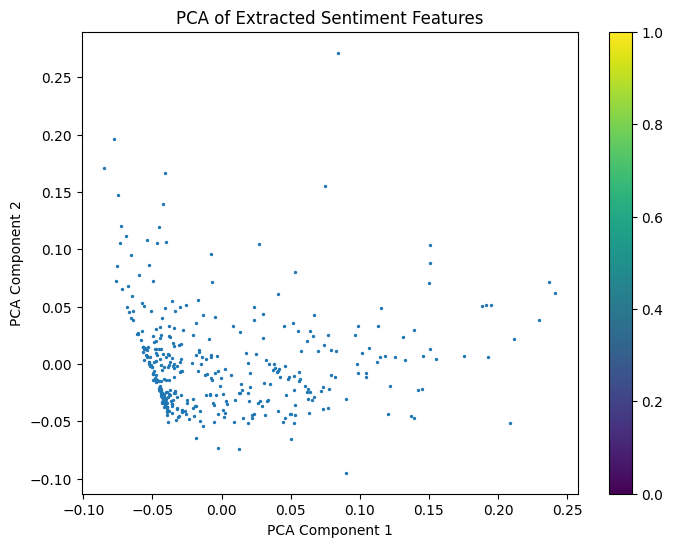

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


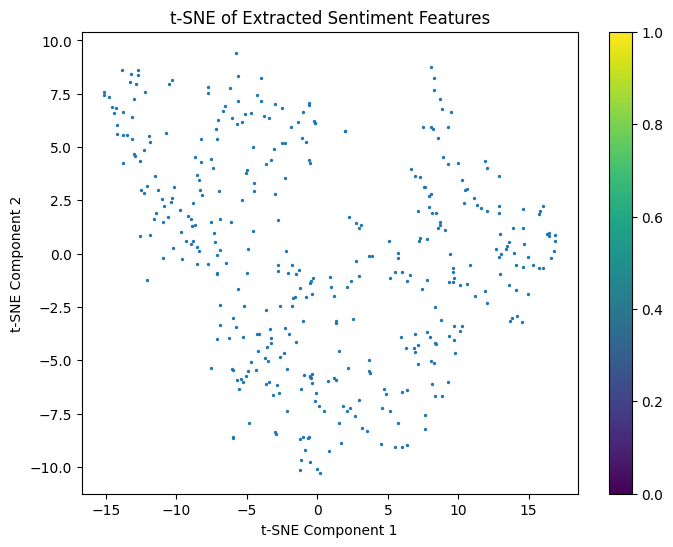

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# 加载保存的特征
sentiment_features_train = np.load('/content/drive/My Drive/sentiment_features_train.npy')
sentiment_features_val = np.load('/content/drive/My Drive/sentiment_features_val.npy')

# PCA可视化
pca = PCA(n_components=2)  # 降到二维
pca_result = pca.fit_transform(sentiment_features_train)  # 对训练数据进行PCA降维

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=2)  # 绘制散点图
plt.title('PCA of Extracted Sentiment Features')  # 图表标题
plt.xlabel('PCA Component 1')  # x轴标签
plt.ylabel('PCA Component 2')  # y轴标签
plt.colorbar()  # 显示颜色条
plt.show()

# t-SNE可视化
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # 设置t-SNE降维参数
tsne_result = tsne.fit_transform(sentiment_features_train)  # 对训练数据进行t-SNE降维

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=2)  # 绘制散点图
plt.title('t-SNE of Extracted Sentiment Features')  # 图表标题
plt.xlabel('t-SNE Component 1')  # x轴标签
plt.ylabel('t-SNE Component 2')  # y轴标签
plt.colorbar()  # 显示颜色条
plt.show()


Trading Dynamics Mode

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import os

# 加载数据集
def load_data(file_path):
    """
    加载CSV文件数据，并将 'Open time' 列转换为日期时间格式，设置为索引。

    参数：
    - file_path：数据文件路径

    返回：
    - data：加载后的数据集，'Open time' 列已被转换为索引。
    """
    data = pd.read_csv(file_path)
    data['Open time'] = pd.to_datetime(data['Open time'])  # 将 'Open time' 列转换为日期时间格式
    data.set_index('Open time', inplace=True)  # 设置 'Open time' 为索引
    return data

# 生成并保存图表
def save_plot(df, chart_type, title, filename):
    """
    根据图表类型生成图表并保存为PNG文件。

    参数：
    - df：数据集
    - chart_type：图表类型（'candle' 表示蜡烛图，其他表示线性图）
    - title：图表标题
    - filename：保存的文件名
    """
    if chart_type == 'candle':
        mpf.plot(df, type='candle', style='charles', volume=True, savefig=f'{filename}.png')  # 生成蜡烛图
    else:
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df)  # 绘制线图
        plt.title(title)
        plt.legend()
        plt.savefig(f'{filename}.png')  # 保存图表
        plt.close()

# 生成所有图表并保存
def generate_and_save_charts(data):
    """
    生成并保存多个技术分析图表：蜡烛图、移动平均线、RSI、MACD、布林带。

    参数：
    - data：数据集
    """
    os.makedirs('charts', exist_ok=True)  # 创建保存图表的文件夹

    # 蜡烛图
    df_daily = data.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    df_daily.dropna(inplace=True)  # 删除缺失值
    save_plot(df_daily, 'candle', '每日 BTC-USD 蜡烛图', 'charts/candlestick')  # 保存蜡烛图

    # 移动平均线图
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='收盘价')
    plt.plot(data.index, data['SMA_12'], label='SMA 12')
    plt.plot(data.index, data['EMA_12'], label='EMA 12')
    plt.legend()
    plt.savefig('charts/moving_averages.png')  # 保存移动平均线图
    plt.close()

    # RSI图
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')  # 70水平线
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')  # 30水平线
    plt.legend()
    plt.savefig('charts/rsi.png')  # 保存RSI图
    plt.close()

    # MACD图
    fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 7), sharex=True)
    ax1.plot(data.index, data['MACD'], label='MACD', color='blue')
    ax1.plot(data.index, data['MACD_signal'], label='信号线', color='orange')
    ax1.legend()
    ax1.set_title('MACD')
    ax2.bar(data.index, data['MACD'] - data['MACD_signal'], label='直方图', color='grey', alpha=0.3)
    ax2.legend()
    plt.savefig('charts/macd.png')  # 保存MACD图
    plt.close()

    # 布林带图
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='收盘价')
    plt.plot(data.index, data['bollinger_mavg'], label='中轨')
    plt.plot(data.index, data['bollinger_hband'], label='上轨')
    plt.plot(data.index, data['bollinger_lband'], label='下轨')
    plt.fill_between(data.index, data['bollinger_hband'], data['bollinger_lband'], color='grey', alpha=0.3)  # 填充带状区域
    plt.legend()
    plt.savefig('charts/bollinger_bands.png')  # 保存布林带图
    plt.close()

# CSV文件路径
data = load_data('/content/drive/MyDrive/bimodel_dataset.csv')

# 生成并保存所有图表
generate_and_save_charts(data)


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from glob import glob
from tensorflow.keras import layers, models, Input, Model

# 加载图像并转换为numpy数组
def load_chart_images(folder_path):
    """
    加载指定文件夹中的所有PNG格式图像，并将它们转换为numpy数组。

    参数：
    - folder_path：图像文件夹的路径。

    返回：
    - np.array：图像数组。
    """
    images = []
    for img_path in glob(f'{folder_path}/*.png'):
        img = load_img(img_path, target_size=(224, 224))  # 将图像调整为224x224大小
        img_array = img_to_array(img)  # 将图像转换为数组
        images.append(img_array)
    return np.array(images)

# 为每种图表类型加载图像
candlestick_images = load_chart_images('charts/candlestick')
moving_avg_images = load_chart_images('charts/moving_averages')
rsi_images = load_chart_images('charts/rsi')
macd_images = load_chart_images('charts/macd')
bollinger_images = load_chart_images('charts/bollinger_bands')

# CNN分支模型
def build_cnn_branch(input_shape):
    """
    构建一个卷积神经网络（CNN）分支，用于从图像中提取特征。

    参数：
    - input_shape：输入图像的形状。

    返回：
    - cnn：CNN模型，包含卷积层和池化层。
    """
    cnn = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # 卷积层，32个3x3的滤波器
        layers.MaxPooling2D((2, 2)),  # 最大池化层，池化窗口为2x2
        layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层，64个3x3的滤波器
        layers.MaxPooling2D((2, 2)),  # 最大池化层
        layers.Conv2D(128, (3, 3), activation='relu'),  # 卷积层，128个3x3的滤波器
        layers.MaxPooling2D((2, 2)),  # 最大池化层
        layers.Flatten()  # 展平层，将卷积输出展平为1D
    ])
    return cnn

input_shape = (224, 224, 3)

# 为不同的图表类型定义输入层
candlestick_input = Input(shape=input_shape)
moving_avg_input = Input(shape=input_shape)
rsi_input = Input(shape=input_shape)
macd_input = Input(shape=input_shape)
bollinger_input = Input(shape=input_shape)

# 为不同的图表类型构建CNN分支
candlestick_cnn = build_cnn_branch(input_shape)(candlestick_input)
moving_avg_cnn = build_cnn_branch(input_shape)(moving_avg_input)
rsi_cnn = build_cnn_branch(input_shape)(rsi_input)
macd_cnn = build_cnn_branch(input_shape)(macd_input)
bollinger_cnn = build_cnn_branch(input_shape)(bollinger_input)

# 将所有提取的特征进行拼接
concatenated_features = layers.concatenate([candlestick_cnn, moving_avg_cnn, rsi_cnn, macd_cnn, bollinger_cnn])

# LSTM层/GRU层，用于捕捉时序关系
lstm_features = layers.Reshape((5, -1))(concatenated_features)  # 重塑数据以适应LSTM输入
lstm_layer = layers.LSTM(128, return_sequences=True)(lstm_features)  # LSTM层，捕捉时序特征

# 全连接层
dense_layer = layers.Flatten()(lstm_layer)  # 展平LSTM的输出
dense_layer = layers.Dense(128, activation='relu')(dense_layer)  # 全连接层，128个神经元
output_layer = layers.Dense(64, activation='relu')(dense_layer)  # 输出层，64个神经元

# 构建模型
model = Model(inputs=[candlestick_input, moving_avg_input, rsi_input, macd_input, bollinger_input], outputs=output_layer)

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 显示模型结构
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 86528)          │         93,248 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 86528)          │         93,248 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 86528)          │         93,248 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 86528)          │         93,248 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 86528)          │         93,248 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 432640)         │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_1[0][0],    │
│                           │                        │                │ sequential_2[0][0],    │
│                           │                        │                │ sequential_3[0][0],    │
│                           │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 5, 86528)       │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 5, 128)         │     44,368,384 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 640)            │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         82,048 │ flatten_5[0][0]        │
├──────────────────────

 Total params: 44,924,928 (171.38 MB)

 Trainable params: 44,924,928 (171.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

# 生成随机图像数据（5张尺寸为224x224，具有3个颜色通道的图像）
candlestick_images = np.random.rand(5, 224, 224, 3)
moving_avg_images = np.random.rand(5, 224, 224, 3)
rsi_images = np.random.rand(5, 224, 224, 3)
macd_images = np.random.rand(5, 224, 224, 3)
bollinger_images = np.random.rand(5, 224, 224, 3)

# 假设 'model' 已经定义并编译（如之前的代码中所示）
# 使用输入数据从模型中提取特征
features = model.predict([candlestick_images, moving_avg_images, rsi_images, macd_images, bollinger_images])

# 输出提取的特征的形状
print(features.shape)  # 应该是 (number_of_images, 64)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(5, 64)


In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 对提取的特征进行K-Means聚类
kmeans = KMeans(n_clusters=5)  # 设置聚类数量为5
kmeans.fit(features)  # 训练模型
labels = kmeans.labels_  # 获取聚类标签

# 可视化聚类结果
plt.scatter(features[:, 0], features[:, 1], c=labels)  # 按聚类标签着色
plt.title('特征聚类')  # 图表标题
plt.xlabel('特征 1')  # x轴标签
plt.ylabel('特征 2')  # y轴标签
plt.colorbar(label='聚类标签')  # 显示聚类标签的颜色条
plt.show()  # 显示图表


NameError: name 'features' is not defined

Submodel test

In [ ]:
!pip install shap

Price Features MAE: 709.2238111076731
Price Features MSE: 916571.8861233178
Sentiment Features MAE: 7947.115954517327
Sentiment Features MSE: 110575609.00595193


  0%|          | 0/101 [00:00<?, ?it/s]

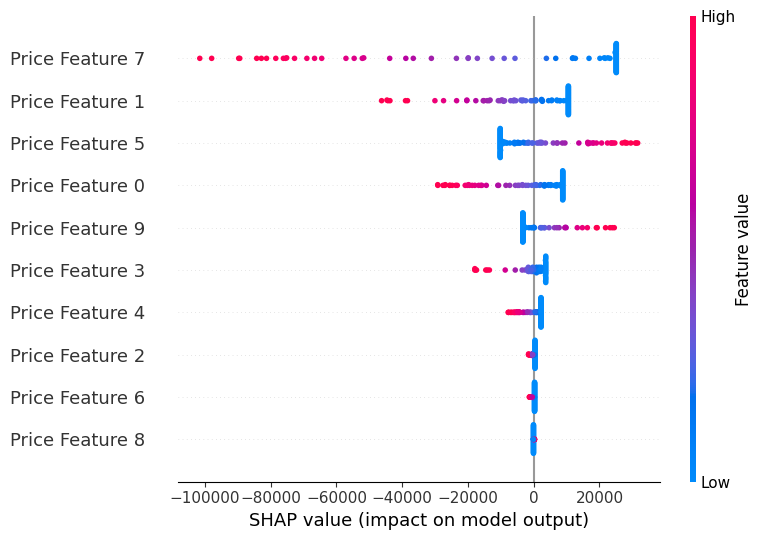

  0%|          | 0/101 [00:00<?, ?it/s]

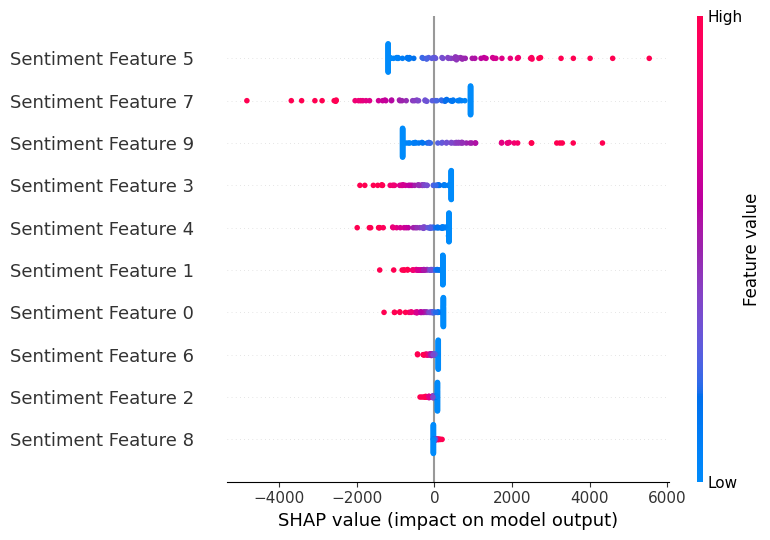

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, MultiHeadAttention, LayerNormalization, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

# 加载特征数据
price_features_train = np.load('/content/drive/My Drive/pa_features_train.npy')
price_features_val = np.load('/content/drive/My Drive/pa_features_val.npy')
sentiment_features_train = np.load('/content/drive/My Drive/sentiment_features_train.npy')
sentiment_features_val = np.load('/content/drive/My Drive/sentiment_features_val.npy')

# 加载目标数据
bimodel_dataset_path = '/content/drive/My Drive/bimodel_dataset.csv'
bimodel_dataset = pd.read_csv(bimodel_dataset_path)
y = bimodel_dataset['Close'].values
num_samples = (len(y) // 24) * 24
y = y[:num_samples]
y = y.reshape(-1, 24)[:, -1]

# 分割目标数据
y_train, y_val = train_test_split(y, test_size=0.2, random_state=42)

# 评估价格行为特征
lr = LinearRegression()
lr.fit(price_features_train, y_train)
price_pred = lr.predict(price_features_val)
print(f'Price Features MAE: {mean_absolute_error(y_val, price_pred)}')
print(f'Price Features MSE: {mean_squared_error(y_val, price_pred)}')

# 评估情感特征
lr.fit(sentiment_features_train, y_train)
sentiment_pred = lr.predict(sentiment_features_val)
print(f'Sentiment Features MAE: {mean_absolute_error(y_val, sentiment_pred)}')
print(f'Sentiment Features MSE: {mean_squared_error(y_val, sentiment_pred)}')

# 特征重要性分析
# 使用SHAP值进行解释

# 对价格特征的SHAP值分析
explainer_price = shap.KernelExplainer(lr.predict, price_features_val)
shap_values_price = explainer_price.shap_values(price_features_val)

# 绘制SHAP值的总结图
shap.summary_plot(shap_values_price, price_features_val, feature_names=['Price Feature ' + str(i) for i in range(price_features_val.shape[1])])

# 对情感特征的SHAP值分析
explainer_sentiment = shap.KernelExplainer(lr.predict, sentiment_features_val)
shap_values_sentiment = explainer_sentiment.shap_values(sentiment_features_val)

# 绘制SHAP值的总结图
shap.summary_plot(shap_values_sentiment, sentiment_features_val, feature_names=['Sentiment Feature ' + str(i) for i in range(sentiment_features_val.shape[1])])


前面是数据处理与特征提取

后面是主要内容

安装依赖

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout, Input, MultiHeadAttention, LayerNormalization, Flatten, Concatenate, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MeanSquaredError
from transformers import BigBirdConfig, BigBirdModel


数据预处理函数

加载数据，清洗数据，进行特征缩放，并最终调整数据形状以便用于模型训练。

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 数据预处理函数
def preprocess_data(file_path):
    # 加载数据集
    df = pd.read_csv(file_path)

    # 删除缺失值
    df.dropna(inplace=True)

    # 过滤掉价格或成交量为负值的数据
    df = df[(df['Close'] > 0) & (df['Volume'] > 0)]

    # 定义价格特征和情感特征
    price_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'MACD_signal', 'MACD_hist', 'slowk', 'slowd']
    sentiment_features = ['vader_sentiment_title', 'vader_sentiment_text', 'bert_sentiment_title', 'bert_sentiment_text']

    # 使用StandardScaler标准化特征
    scaler = StandardScaler()
    df[price_features] = scaler.fit_transform(df[price_features])
    df[sentiment_features] = scaler.fit_transform(df[sentiment_features])

    # 提取特征矩阵
    X_price = df[price_features].values
    X_sentiment = df[sentiment_features].values
    y = df['Close'].values

    # 确保数据长度是24的倍数，方便后续reshape
    num_samples = (len(X_price) // 24) * 24
    X_price = X_price[:num_samples]
    X_sentiment = X_sentiment[:num_samples]
    y = y[:num_samples]

    # 调整数据形状，适配LSTM和Conv1D的输入要求
    X_price = X_price.reshape(-1, 24, len(price_features))
    X_sentiment = X_sentiment.reshape(-1, 24, len(sentiment_features))

    # 我们预测的是最后一个时间步的收盘价格
    y = y.reshape(-1, 24)[:, -1]

    return X_price, X_sentiment, y


价格模态模型（TCN）

一个处理价格数据的时间卷积网络（TCN）模型。该模型提取能够捕捉价格数据中时间依赖性的特征。

In [15]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Input, Flatten, Dense
from tensorflow.keras.models import Model

# 价格模态的TCN块
def tcn_block(x, filters=64, kernel_size=2, dilation_rate=1):
    """
    时间卷积网络（TCN）块。
    - Conv1D：应用扩张卷积来捕捉长期依赖关系。
    - BatchNormalization：对激活进行归一化，提高训练的稳定性。
    - Dropout：应用Dropout防止过拟合。

    参数：
    - x：输入张量。
    - filters：Conv1D层的过滤器数量（默认为64）。
    - kernel_size：卷积核的大小（默认为2）。
    - dilation_rate：卷积的扩张率（默认为1）。

    返回：
    - x：经过Conv1D、BatchNormalization和Dropout处理后的输出张量。
    """
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    return x

# 价格模态模型
def price_action_model(input_shape):
    """
    使用时间卷积网络（TCN）块的价格模态模型。
    - 应用一系列TCN块来提取特征。
    - 将输出展平并通过一个Dense层提取特征。

    参数：
    - input_shape：输入数据的形状。

    返回：
    - Model：Keras模型对象，包含输入和输出层。
    """
    inputs = Input(shape=input_shape)

    # 使用不同扩张率的多个TCN块
    x = tcn_block(inputs, filters=64, kernel_size=2, dilation_rate=1)
    x = tcn_block(x, filters=64, kernel_size=2, dilation_rate=2)
    x = tcn_block(x, filters=64, kernel_size=2, dilation_rate=4)

    # 展平TCN块的输出
    x = Flatten()(x)

    # 特征提取层
    features = Dense(20, activation='relu', name='price_feature_layer')(x)

    return Model(inputs, features)


情感模态模型（自编码器 + LSTM）

该情感模态模型结合了自编码器和LSTM层。首先，它通过自编码器降低数据的维度，然后通过LSTM学习情感数据中的时序模式。

In [16]:
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# 自编码器 + LSTM 模型用于情感模态
def autoencoder_lstm_model(input_shape):
    """
    构建一个自编码器与LSTM相结合的模型，用于情感模态的特征提取。
    - 自编码器部分：用于降维并重构输入数据。
    - LSTM部分：用于提取序列数据的时序特征。

    参数：
    - input_shape：输入数据的形状。

    返回：
    - autoencoder：自编码器模型，用于重构输入数据。
    - sentiment_model：情感模型，用于提取特征。
    """
    inputs = Input(shape=input_shape)

    # 自编码器部分
    encoded = LSTM(128, activation='relu')(inputs)  # 编码层，提取特征
    encoded = Dense(64, activation='relu')(encoded)  # 压缩后的特征
    decoded = Dense(input_shape[1], activation='relu')(encoded)  # 解码层，重构输入数据
    autoencoder = Model(inputs, decoded)  # 自编码器模型

    # LSTM部分
    x = LSTM(128, return_sequences=True)(inputs)  # 第一层LSTM，返回序列
    x = BatchNormalization()(x)  # 批归一化层
    x = Dropout(0.5)(x)  # Dropout层，防止过拟合
    x = LSTM(64, return_sequences=True)(x)  # 第二层LSTM，返回序列
    x = BatchNormalization()(x)  # 批归一化层
    x = Dropout(0.5)(x)  # Dropout层
    x = LSTM(32, return_sequences=False)(x)  # 第三层LSTM，返回最后一个时刻的输出
    x = BatchNormalization()(x)  # 批归一化层
    x = Dropout(0.5)(x)  # Dropout层

    # 特征提取层
    features = Dense(20, activation='relu', name='sentiment_feature_layer')(x)

    return autoencoder, Model(inputs, features)


自定义损失函数

这个自定义损失函数在模型的预测准确性（均方误差，MSE）与残差的波动性之间进行平衡，从而提供对模型性能的更细致评估。

In [17]:
# 自定义多目标损失函数
class MultiObjectiveLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, name='multi_objective_loss'):
        super().__init__(name=name)
        self.alpha = alpha  # Alpha 用于在准确度和波动性之间进行平衡

    def call(self, y_true, y_pred):
        mse = MeanSquaredError()(y_true, y_pred)  # 计算均方误差
        residuals = y_true - y_pred  # 计算残差
        volatility = tf.math.reduce_std(residuals)  # 计算残差的标准差，作为波动性
        return self.alpha * mse + (1 - self.alpha) * volatility  # 综合损失函数，包括准确度和波动性


注意力机制定义

我们定义了各种注意力机制，包括自注意力、缩放点积注意力、多头注意力和BigBird注意力。这些机制帮助模型集中关注输入序列中的重要特征。

In [18]:
# 自注意力块
class SelfAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        # 定义 Q、K、V 的密集层
        self.q_dense = Dense(kwargs.get('units', 128))
        self.k_dense = Dense(kwargs.get('units', 128))
        self.v_dense = Dense(kwargs.get('units', 128))
        # 归一化层
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # 计算 Q、K、V
        q = self.q_dense(inputs)
        k = self.k_dense(inputs)
        v = self.v_dense(inputs)
        # 计算注意力
        attention = tf.matmul(q, k, transpose_b=True)
        attention = tf.nn.softmax(attention, axis=-1)  # 在最后一个维度应用 softmax
        attention = tf.matmul(attention, v)
        attention = self.layer_norm(attention)  # 应用归一化
        return attention

# 缩放点积注意力块
class ScaledDotProductAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttentionBlock, self).__init__(**kwargs)
        # 定义 Q、K、V 的密集层
        self.q_dense = Dense(kwargs.get('units', 128))
        self.k_dense = Dense(kwargs.get('units', 128))
        self.v_dense = Dense(kwargs.get('units', 128))
        # 使用缩放点积注意力
        self.scaled_dot_product_attention = ScaledDotProductAttention()
        # 归一化层
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # 计算 Q、K、V
        q = self.q_dense(inputs)
        k = self.k_dense(inputs)
        v = self.v_dense(inputs)
        # 使用缩放点积注意力
        attention = self.scaled_dot_product_attention([q, k, v])
        attention = self.layer_norm(attention)  # 应用归一化
        return attention

# 缩放点积注意力层
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def call(self, inputs):
        q, k, v = inputs
        # 计算 Q 和 K 的点积
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        # 计算缩放系数
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        # 计算注意力权重
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # 计算输出
        output = tf.matmul(attention_weights, v)
        return output

# 多头注意力块
class MultiHeadAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(MultiHeadAttentionBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        # 使用多头注意力层
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=kwargs.get('key_dim', 128))
        # 归一化层
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # 计算多头注意力
        attention = self.mha(inputs, inputs)
        attention = self.layer_norm(attention)  # 应用归一化
        return attention

# BigBird 注意力块
class BigBirdAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(BigBirdAttentionBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        # 使用多头注意力
        self.attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=kwargs.get('key_dim', 128))
        # 归一化层
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # 计算 BigBird 注意力
        attention_output = self.attention(inputs, inputs)
        attention_output = self.layer_norm(attention_output)  # 应用归一化
        return attention_output


融合模型的定义

融合模型将价格和情感特征进行整合，应用不同的注意力机制，并结合这些特征进行最终预测。该模型旨在探索各种注意力策略，以找到最有效的方案。

In [19]:
# 融合模型：结合价格和情感模态，并应用注意力机制
def fusion_model(price_input_shape, sentiment_input_shape, attention_type='self_attention', num_heads=8, alpha=0.5):
    # 定义价格和情感输入
    price_inputs = Input(shape=price_input_shape)
    sentiment_inputs = Input(shape=sentiment_input_shape)

    # 从价格和情感模型中获取特征
    price_features = price_action_model(price_input_shape)(price_inputs)
    sentiment_features = autoencoder_lstm_model(sentiment_input_shape)[1](sentiment_inputs)

    # 将价格特征和情感特征拼接
    concatenated = Concatenate()([price_features, sentiment_features])

    # 扩展维度以适应注意力层
    concatenated = Lambda(lambda x: tf.expand_dims(x, axis=1))(concatenated)

    # 应用选定的注意力机制
    if attention_type.startswith('multi_head'):
        attention = MultiHeadAttentionBlock(num_heads=num_heads)(concatenated)
    elif attention_type.startswith('bigbird'):
        attention = BigBirdAttentionBlock(num_heads=num_heads)(concatenated)
    elif attention_type == 'self_attention':
        attention = SelfAttentionBlock()(concatenated)
    elif attention_type == 'scaled_dot_product':
        attention = ScaledDotProductAttentionBlock()(concatenated)
    else:
        raise ValueError(f'Unknown attention type: {attention_type}')

    # 去除多余的维度
    attention = Lambda(lambda x: tf.squeeze(x, axis=1))(attention)

    # 应用层归一化
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # 最终的全连接层和输出
    x = Dense(128, activation='relu')(attention)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1)(x)

    # 使用自定义损失函数编译模型
    multi_objective_loss = MultiObjectiveLoss(alpha=alpha)
    model = Model(inputs=[price_inputs, sentiment_inputs], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=multi_objective_loss, metrics=['mae'])

    return model


训练和评估

我们现在使用不同的注意力机制来训练模型，并评估它们的性能。
我们还将可视化训练过程、损失，并进行预测。

In [20]:
# 训练和评估使用不同注意力机制的模型
file_path = '/content/drive/My Drive/bimodel_dataset.csv'

# 数据预处理
X_price, X_sentiment, y = preprocess_data(file_path)

# 划分训练集和验证集
X_price_train, X_price_val, X_sentiment_train, X_sentiment_val, y_train, y_val = train_test_split(
    X_price, X_sentiment, y, test_size=0.2, random_state=42)

# 定义价格和情感数据的输入形状
price_input_shape = (24, 10)
sentiment_input_shape = (24, 4)

# 探索不同的注意力机制和头数
attention_types = ['self_attention', 'scaled_dot_product', 'multi_head', 'bigbird']
num_heads_options = [4, 8, 12]
results = []  # 用来存储结果
alpha = 0.5   # alpha参数平衡准确性和波动性

# 遍历不同的注意力机制和头数
for attention_type in attention_types:
    if attention_type in ['multi_head', 'bigbird']:
        for num_heads in num_heads_options:
            # 构建模型
            model = fusion_model(price_input_shape, sentiment_input_shape, attention_type=f'{attention_type}_{num_heads}', num_heads=num_heads, alpha=alpha)
            model.summary()

            # 定义回调函数
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ModelCheckpoint(f'best_fusion_model_{attention_type}_{num_heads}_heads.keras', monitor='val_loss', save_best_only=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
            ]

            # 训练模型
            history = model.fit(
                [X_price_train, X_sentiment_train], y_train,
                validation_data=([X_price_val, X_sentiment_val], y_val),
                epochs=50, batch_size=32, callbacks=callbacks
            )

            # 保存训练结果
            results.append({
                'attention_type': f'{attention_type}_{num_heads}_heads',
                'history': history,
                'num_heads': num_heads
            })
    else:
        # 对于其他类型的注意力机制，直接构建并训练模型
        model = fusion_model(price_input_shape, sentiment_input_shape, attention_type=attention_type, alpha=alpha)
        model.summary()

        # 定义回调函数
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint(f'best_fusion_model_{attention_type}.keras', monitor='val_loss', save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
        ]

        # 训练模型
        history = model.fit(
            [X_price_train, X_sentiment_train], y_train,
            validation_data=([X_price_val, X_sentiment_val], y_val),
            epochs=50, batch_size=32, callbacks=callbacks
        )

        # 保存训练结果
        results.append({
            'attention_type': attention_type,
            'history': history,
            'num_heads': None
        })


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_11             │ (None, 20)             │         49,364 │ input_layer_13[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_13             │ (None, 20)             │        131,476 │ input_layer_14[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 40)             │              0 │ functional_11[0][0],   │
│ (Concatenate)             │                        │                │ functional_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1, 40)          │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ self_attention_block      │ (None, 1, 128)         │         16,000 │ lambda[0][0]           │
│ (SelfAttentionBlock)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128)            │              0 │ self_attention_block[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128)            │            256 │ lambda_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         16,512 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          8,256 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 221,929 (866.91 KB)

 Trainable params: 221,097 (863.66 KB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 2.1324 - mae: 1.2492 - val_loss: 0.8051 - val_mae: 0.5792 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 1.1497 - mae: 0.8287 - val_loss: 0.7412 - val_mae: 0.4752 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.9658 - mae: 0.6886 - val_loss: 0.7351 - val_mae: 0.4720 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.9375 - mae: 0.6542 - val_loss: 0.7121 - val_mae: 0.4396 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.8358 - mae: 0.5374 - val_loss: 0.7168 - val_mae: 0.4566 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.7937 - mae: 0.5588 - val_loss: 0.7431 - val_mae: 0.5097 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.8098 - mae: 0.5409 - val_loss: 0.7224 - val_mae: 0.4869 - learning_rate: 0.0010
Epoch 8/

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_18            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_15             │ (None, 20)             │         49,364 │ input_layer_17[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_17             │ (None, 20)             │        131,476 │ input_layer_18[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 40)             │              0 │ functional_15[0][0],   │
│ (Concatenate)             │                        │                │ functional_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1, 40)          │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaled_dot_product_atten… │ (None, 1, 128)         │         16,000 │ lambda_2[0][0]         │
│ (ScaledDotProductAttenti… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 128)            │              0 │ scaled_dot_product_at… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 128)            │            256 │ lambda_3[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 128)            │         16,512 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 128)            │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 64)             │          8,256 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 64)             │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 1)              │             65 │ dropout_21[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 221,929 (866.91 KB)

 Trainable params: 221,097 (863.66 KB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - loss: 2.0574 - mae: 1.2486 - val_loss: 0.8063 - val_mae: 0.5784 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 1.2957 - mae: 0.8728 - val_loss: 0.7806 - val_mae: 0.5162 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 1.0458 - mae: 0.7438 - val_loss: 0.7582 - val_mae: 0.5232 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.9206 - mae: 0.6281 - val_loss: 0.7785 - val_mae: 0.5831 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.8462 - mae: 0.5669 - val_loss: 0.7937 - val_mae: 0.5906 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.8126 - mae: 0.5316 - val_loss: 0.8010 - val_mae: 0.5950 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.7805 - mae: 0.5216 - val_loss: 0.7736 - val_mae: 0.5607 - learning_rate: 0.0010
Epoch 8/50

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_19             │ (None, 20)             │         49,364 │ input_layer_21[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_21             │ (None, 20)             │        131,476 │ input_layer_22[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 40)             │              0 │ functional_19[0][0],   │
│ (Concatenate)             │                        │                │ functional_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 1, 40)          │              0 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_blo… │ (None, 1, 40)          │         83,576 │ lambda_4[0][0]         │
│ (MultiHeadAttentionBlock) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 40)             │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 40)             │             80 │ lambda_5[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 128)            │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 64)             │          8,256 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 64)             │              0 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1)              │             65 │ dropout_30[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 278,065 (1.06 MB)

 Trainable params: 277,233 (1.06 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 1.2922 - mae: 0.9382 - val_loss: 0.9115 - val_mae: 0.7258 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.8933 - mae: 0.6836 - val_loss: 0.7282 - val_mae: 0.4254 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.8174 - mae: 0.5340 - val_loss: 0.7090 - val_mae: 0.4098 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.7756 - mae: 0.5009 - val_loss: 0.7023 - val_mae: 0.4252 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.7714 - mae: 0.4718 - val_loss: 0.7009 - val_mae: 0.4316 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.7565 - mae: 0.5269 - val_loss: 0.6976 - val_mae: 0.4355 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.7381 - mae: 0.4454 - val_loss: 0.7047 - val_mae: 0.4352 - learning_rate: 0.0010
Epoch 

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_23             │ (None, 20)             │         49,364 │ input_layer_25[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_25             │ (None, 20)             │        131,476 │ input_layer_26[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 40)             │              0 │ functional_23[0][0],   │
│ (Concatenate)             │                        │                │ functional_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1, 40)          │              0 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_blo… │ (None, 1, 40)          │        167,032 │ lambda_6[0][0]         │
│ (MultiHeadAttentionBlock) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 40)             │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 40)             │             80 │ lambda_7[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 128)            │              0 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 64)             │          8,256 │ dropout_38[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_39 (Dropout)      │ (None, 64)             │              0 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 1)              │             65 │ dropout_39[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 361,521 (1.38 MB)

 Trainable params: 360,689 (1.38 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - loss: 1.6548 - mae: 1.0846 - val_loss: 0.8720 - val_mae: 0.6540 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.9519 - mae: 0.6680 - val_loss: 0.7049 - val_mae: 0.3527 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.8071 - mae: 0.5220 - val_loss: 0.7031 - val_mae: 0.3968 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.7820 - mae: 0.5036 - val_loss: 0.7086 - val_mae: 0.4370 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.7765 - mae: 0.4981 - val_loss: 0.6929 - val_mae: 0.4144 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.7561 - mae: 0.4415 - val_loss: 0.7089 - val_mae: 0.4577 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.7252 - mae: 0.4481 - val_loss: 0.6942 - val_mae: 0.4263 - learning_rate: 0.0010
Epoch 8/

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_30            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_27             │ (None, 20)             │         49,364 │ input_layer_29[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_29             │ (None, 20)             │        131,476 │ input_layer_30[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 40)             │              0 │ functional_27[0][0],   │
│ (Concatenate)             │                        │                │ functional_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ (None, 1, 40)          │              0 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_blo… │ (None, 1, 40)          │        250,488 │ lambda_8[0][0]         │
│ (MultiHeadAttentionBlock) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_9 (Lambda)         │ (None, 40)             │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 40)             │             80 │ lambda_9[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_47 (Dropout)      │ (None, 128)            │              0 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 64)             │          8,256 │ dropout_47[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_48 (Dropout)      │ (None, 64)             │              0 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 1)              │             65 │ dropout_48[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 444,977 (1.70 MB)

 Trainable params: 444,145 (1.69 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - loss: 1.5064 - mae: 1.0429 - val_loss: 0.7728 - val_mae: 0.5176 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.8286 - mae: 0.6070 - val_loss: 0.7303 - val_mae: 0.4398 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.7676 - mae: 0.4721 - val_loss: 0.7026 - val_mae: 0.3974 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.7562 - mae: 0.4848 - val_loss: 0.6780 - val_mae: 0.3362 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.7510 - mae: 0.4567 - val_loss: 0.6944 - val_mae: 0.4371 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.7157 - mae: 0.4257 - val_loss: 0.6885 - val_mae: 0.4271 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.7302 - mae: 0.4181 - val_loss: 0.6907 - val_mae: 0.4487 - learning_rate: 0.0010
Epoch 

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_34            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_31             │ (None, 20)             │         49,364 │ input_layer_33[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_33             │ (None, 20)             │        131,476 │ input_layer_34[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 40)             │              0 │ functional_31[0][0],   │
│ (Concatenate)             │                        │                │ functional_33[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_10 (Lambda)        │ (None, 1, 40)          │              0 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ big_bird_attention_block  │ (None, 1, 40)          │         83,576 │ lambda_10[0][0]        │
│ (BigBirdAttentionBlock)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_11 (Lambda)        │ (None, 40)             │              0 │ big_bird_attention_bl… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 40)             │             80 │ lambda_11[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_56 (Dropout)      │ (None, 128)            │              0 │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 64)             │          8,256 │ dropout_56[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 64)             │              0 │ dense_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1)              │             65 │ dropout_57[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 278,065 (1.06 MB)

 Trainable params: 277,233 (1.06 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - loss: 1.4500 - mae: 1.0366 - val_loss: 0.7859 - val_mae: 0.5861 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.8985 - mae: 0.6716 - val_loss: 0.7143 - val_mae: 0.4754 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.7680 - mae: 0.5013 - val_loss: 0.6991 - val_mae: 0.4560 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.7843 - mae: 0.4936 - val_loss: 0.7186 - val_mae: 0.4693 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.7623 - mae: 0.4699 - val_loss: 0.7010 - val_mae: 0.4783 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.7698 - mae: 0.4955 - val_loss: 0.6984 - val_mae: 0.4708 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.7595 - mae: 0.4689 - val_loss: 0.6833 - val_mae: 0.4349 - learning_rate: 0.0010
Epoch

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_35             │ (None, 20)             │         49,364 │ input_layer_37[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_37             │ (None, 20)             │        131,476 │ input_layer_38[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 40)             │              0 │ functional_35[0][0],   │
│ (Concatenate)             │                        │                │ functional_37[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 1, 40)          │              0 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ big_bird_attention_block… │ (None, 1, 40)          │        167,032 │ lambda_12[0][0]        │
│ (BigBirdAttentionBlock)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_13 (Lambda)        │ (None, 40)             │              0 │ big_bird_attention_bl… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 40)             │             80 │ lambda_13[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 128)            │              0 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 64)             │          8,256 │ dropout_65[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_66 (Dropout)      │ (None, 64)             │              0 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 1)              │             65 │ dropout_66[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 361,521 (1.38 MB)

 Trainable params: 360,689 (1.38 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - loss: 1.3952 - mae: 0.9477 - val_loss: 0.7087 - val_mae: 0.3817 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.8933 - mae: 0.6123 - val_loss: 0.6955 - val_mae: 0.3432 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.7467 - mae: 0.4681 - val_loss: 0.6972 - val_mae: 0.3510 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.7390 - mae: 0.4576 - val_loss: 0.6823 - val_mae: 0.3519 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.7328 - mae: 0.4528 - val_loss: 0.6725 - val_mae: 0.3463 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.7640 - mae: 0.4662 - val_loss: 0.6883 - val_mae: 0.4118 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.7400 - mae: 0.4744 - val_loss: 0.6717 - val_mae: 0.3531 - learning_rate: 0.0010
Epoch 8

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_42            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_39             │ (None, 20)             │         49,364 │ input_layer_41[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_41             │ (None, 20)             │        131,476 │ input_layer_42[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 40)             │              0 │ functional_39[0][0],   │
│ (Concatenate)             │                        │                │ functional_41[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_14 (Lambda)        │ (None, 1, 40)          │              0 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ big_bird_attention_block… │ (None, 1, 40)          │        250,488 │ lambda_14[0][0]        │
│ (BigBirdAttentionBlock)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_15 (Lambda)        │ (None, 40)             │              0 │ big_bird_attention_bl… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 40)             │             80 │ lambda_15[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_74 (Dropout)      │ (None, 128)            │              0 │ dense_47[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 64)             │          8,256 │ dropout_74[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_75 (Dropout)      │ (None, 64)             │              0 │ dense_48[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_49 (Dense)          │ (None, 1)              │             65 │ dropout_75[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 444,977 (1.70 MB)

 Trainable params: 444,145 (1.69 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 1.6004 - mae: 1.1027 - val_loss: 0.7898 - val_mae: 0.5293 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.9357 - mae: 0.6417 - val_loss: 0.7478 - val_mae: 0.4620 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.7930 - mae: 0.5174 - val_loss: 0.7036 - val_mae: 0.3488 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.7540 - mae: 0.4481 - val_loss: 0.7192 - val_mae: 0.4266 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 0.7843 - mae: 0.5072 - val_loss: 0.7011 - val_mae: 0.4035 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.7334 - mae: 0.4254 - val_loss: 0.6832 - val_mae: 0.3600 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.7375 - mae: 0.4569 - val_loss: 0.7032 - val_mae: 0.4263 - learning_rate: 0.0010
Epoch

可视化训练过程

我们绘制每种注意力机制的训练和验证损失曲线，便于通过视觉效果比较它们的性能。

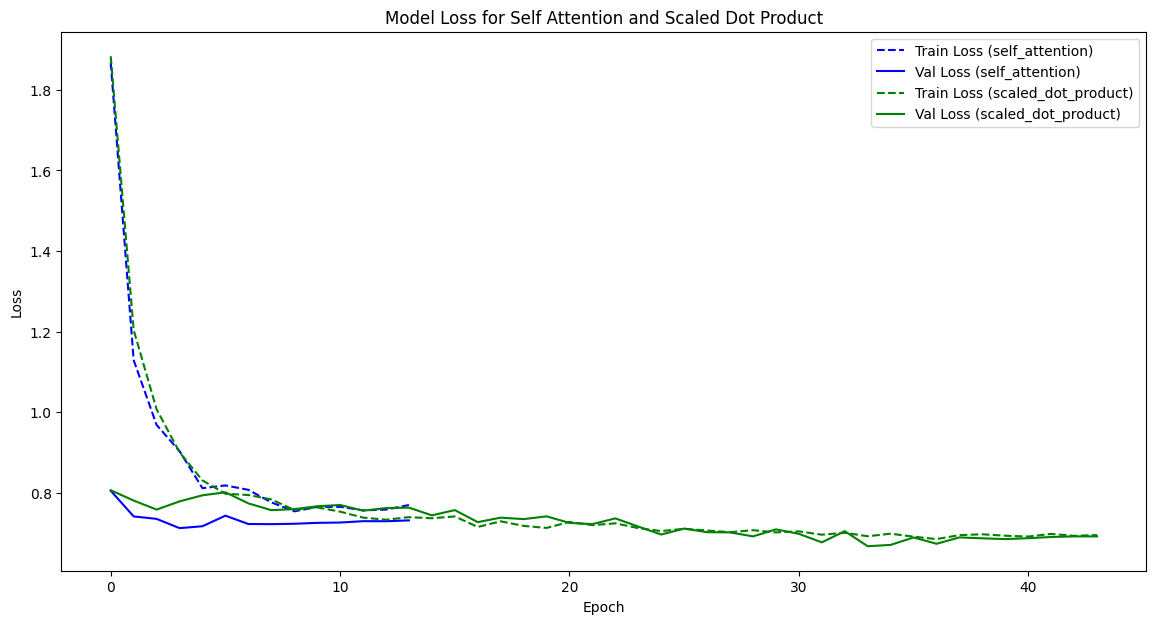

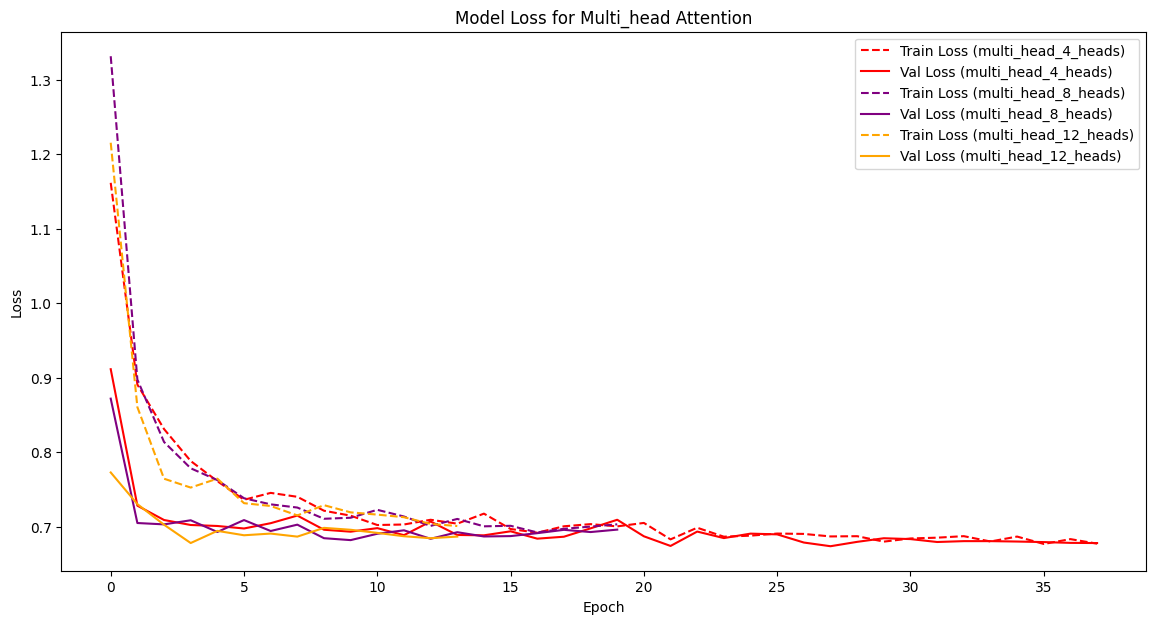

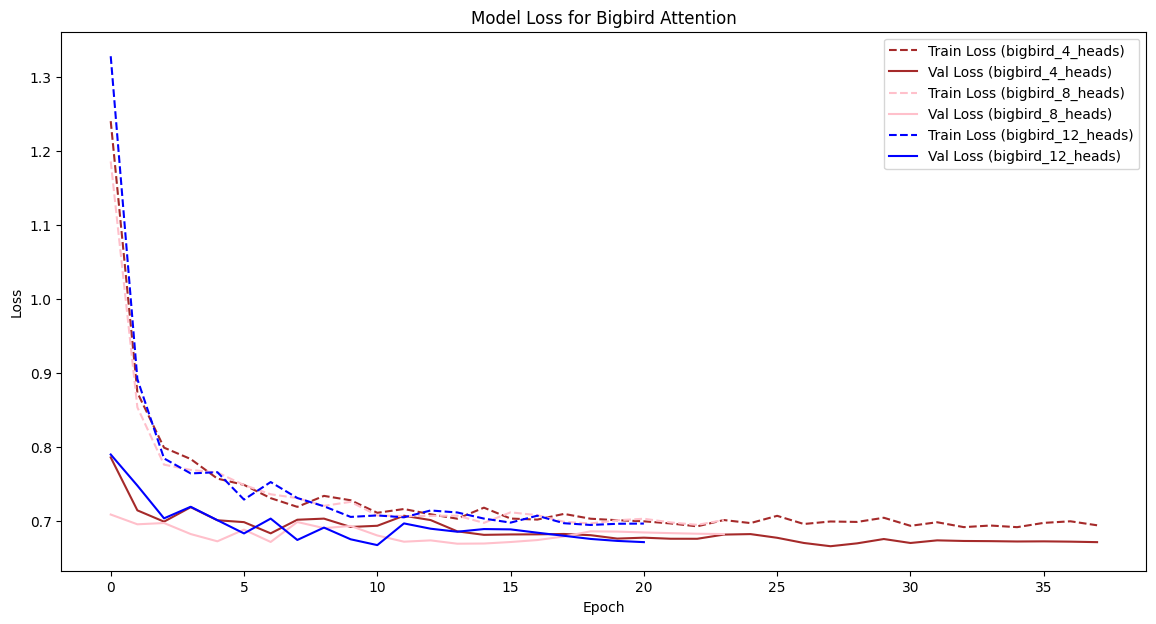

In [21]:
import itertools
import matplotlib.pyplot as plt

# 绘制不同注意力机制的损失曲线
def plot_loss_curves(results):
    # 定义颜色循环
    color_cycle = itertools.cycle(['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink'])
    color_dict = {}

    # 为每种注意力机制分配一个颜色
    for result in results:
        attention_type = result['attention_type']
        if attention_type not in color_dict:
            color_dict[attention_type] = next(color_cycle)

    # 绘制自注意力和缩放点积注意力的损失曲线
    plt.figure(figsize=(14, 7))
    for attention_type in ['self_attention', 'scaled_dot_product']:
        for result in results:
            if attention_type in result['attention_type']:
                history = result['history']
                color = color_dict[result['attention_type']]
                plt.plot(history.history['loss'], linestyle='--', color=color, label=f'Train Loss ({result["attention_type"]})')
                plt.plot(history.history['val_loss'], linestyle='-', color=color, label=f'Val Loss ({result["attention_type"]})')
    plt.title('Model Loss for Self Attention and Scaled Dot Product')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # 绘制多头注意力和BigBird注意力的损失曲线
    for attention_type in ['multi_head', 'bigbird']:
        plt.figure(figsize=(14, 7))
        for result in results:
            if attention_type in result['attention_type']:
                history = result['history']
                color = color_dict[result['attention_type']]
                plt.plot(history.history['loss'], linestyle='--', color=color, label=f'Train Loss ({result["attention_type"]})')
                plt.plot(history.history['val_loss'], linestyle='-', color=color, label=f'Val Loss ({result["attention_type"]})')
        plt.title(f'Model Loss for {attention_type.capitalize()} Attention')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

# 调用函数绘制损失曲线
plot_loss_curves(results)


模型评估

在训练后，我们计算并显示关键的性能指标，如均方误差（MSE）和均值绝对误差（MAE），用于评估训练集和验证集的表现。

In [22]:
# 打印每个模型的评估指标
def print_metrics(results):
    for result in results:
        attention_type = result['attention_type']
        history = result['history']
        # 计算训练集的最小均方误差
        train_mse = min(history.history['loss'])
        # 计算验证集的最小均方误差
        val_mse = min(history.history['val_loss'])
        # 计算训练集的最小平均绝对误差
        train_mae = min(history.history['mae'])
        # 计算验证集的最小平均绝对误差
        val_mae = min(history.history['val_mae'])

        # 输出训练集和验证集的均方误差和平均绝对误差
        print(f'{attention_type} - Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}')
        print(f'Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')

# 调用函数输出各模型的评估结果
print_metrics(results)


self_attention - Train MSE: 0.7538, Val MSE: 0.7121
Train MAE: 0.4545, Val MAE: 0.4396
scaled_dot_product - Train MSE: 0.6849, Val MSE: 0.6673
Train MAE: 0.3405, Val MAE: 0.3905
multi_head_4_heads - Train MSE: 0.6768, Val MSE: 0.6738
Train MAE: 0.3288, Val MAE: 0.3929
multi_head_8_heads - Train MSE: 0.6923, Val MSE: 0.6820
Train MAE: 0.3661, Val MAE: 0.3527
multi_head_12_heads - Train MSE: 0.7009, Val MSE: 0.6780
Train MAE: 0.3777, Val MAE: 0.3362
bigbird_4_heads - Train MSE: 0.6916, Val MSE: 0.6659
Train MAE: 0.3505, Val MAE: 0.3874
bigbird_8_heads - Train MSE: 0.6947, Val MSE: 0.6693
Train MAE: 0.3477, Val MAE: 0.3432
bigbird_12_heads - Train MSE: 0.6946, Val MSE: 0.6674
Train MAE: 0.3602, Val MAE: 0.3488


最终预测和注意力权重可视化


这一部分可视化了模型在训练集和验证集上的最终预测结果。同时，它还提取并展示了模型的注意力权重，以帮助解释模型是如何关注输入数据的不同部分的。

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# 绘制最终预测图
def plot_final_predictions(model, X_price_train, X_sentiment_train, X_price_val, X_sentiment_val, y_train, y_val, attention_type):
    """
    绘制训练集和验证集的预测结果对比图。

    参数：
    model: 训练好的模型
    X_price_train, X_sentiment_train: 训练集的价格和情感特征
    X_price_val, X_sentiment_val: 验证集的价格和情感特征
    y_train, y_val: 训练集和验证集的真实价格
    attention_type: 注意力机制类型
    """
    # 获取训练集和验证集的预测结果
    y_pred_train = model.predict([X_price_train, X_sentiment_train]).flatten()
    y_pred_val = model.predict([X_price_val, X_sentiment_val]).flatten()

    # 绘制训练集和验证集的真实价格与预测价格对比
    plt.figure(figsize=(14, 7))
    plt.plot(y_train, label='True Price (Train)', color='blue')
    plt.plot(y_pred_train, label='Predicted Price (Train)', color='cyan')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='True Price (Validation)', color='green')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred_val, label='Predicted Price (Validation)', color='orange')
    plt.title(f'Training and Validation Set Prediction ({attention_type})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 可视化注意力权重
def plot_attention_weights(model, X_price, X_sentiment, attention_type):
    """
    可视化模型的注意力权重，帮助分析模型在输入数据中关注的不同部分。

    参数：
    model: 训练好的模型
    X_price, X_sentiment: 价格和情感特征数据
    attention_type: 注意力机制类型
    """
    # 获取模型的第一个注意力层名称
    intermediate_layer_name = get_first_attention_layer_name(model)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(intermediate_layer_name).output)

    # 获取注意力权重
    attention_weights = intermediate_layer_model.predict([X_price, X_sentiment])

    # 如果返回的是列表，则取第一个元素
    if isinstance(attention_weights, list):
        attention_weights = attention_weights[0]

    # 转换为 numpy 数组
    attention_weights = np.array(attention_weights)

    # 处理不同维度的注意力权重
    if attention_weights.ndim == 4:
        attention_weights = np.squeeze(attention_weights, axis=0)
    elif attention_weights.ndim == 3:
        if attention_weights.shape[0] == 1:
            attention_weights = np.squeeze(attention_weights, axis=0)
        else:
            attention_weights = np.mean(attention_weights, axis=0)
    elif attention_weights.ndim == 2:
        attention_weights = np.expand_dims(attention_weights, axis=0)
    else:
        raise ValueError(f"Invalid shape for attention_weights: {attention_weights.shape}")

    # 绘制注意力权重的热力图
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_weights, cmap='viridis', aspect='auto')
    plt.title(f'Attention Weights ({attention_type})')
    plt.xlabel('Head')
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

    # 计算并显示注意力权重的统计信息
    avg_attention = np.mean(attention_weights)
    max_attention = np.max(attention_weights)
    min_attention = np.min(attention_weights)
    std_attention = np.std(attention_weights)

    print(f'Attention Weights ({attention_type}) - Mean: {avg_attention:.4f}, Max: {max_attention:.4f}, Min: {min_attention:.4f}, Std Dev: {std_attention:.4f}')


最终评估与分析

最后，我们加载最佳模型权重，评估模型在测试数据上的预测结果，并可视化模型提取的中间特征。

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 打印模型的所有层名称
def print_model_layers(model):
    for layer in model.layers:
        print(layer.name)

# 获取模型中第一个注意力层的名称
def get_first_attention_layer_name(model):
    for layer in model.layers:
        if 'attention' in layer.name.lower() or 'bigbird' in layer.name.lower():
            return layer.name
    raise ValueError("No attention layer found in the model.")

# 加载模型权重
def load_model_weights(model, weights_path, alpha=0.5):
    multi_objective_loss = MultiObjectiveLoss(alpha=alpha)
    model.load_weights(weights_path)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=multi_objective_loss, metrics=['mae'])

# 根据部分名称获取模型层的名称
def get_layer_name_by_partial_name(model, partial_name):
    for layer in model.layers:
        if partial_name in layer.name:
            return layer.name
    raise ValueError(f"No layer with partial name '{partial_name}' found in the model.")

# 提取中间层特征
def extract_intermediate_features(model, X_price, X_sentiment, partial_name):
    layer_name = get_layer_name_by_partial_name(model, partial_name)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return intermediate_layer_model.predict([X_price, X_sentiment])

# 可视化中间层特征
def plot_intermediate_features(model, X_price_train, X_sentiment_train, X_price_val, X_sentiment_val, attention_type):
    """
    提取并可视化中间层的特征，包括训练集和验证集。
    """
    partial_name = 'dense_'
    try:
        train_features = extract_intermediate_features(model, X_price_train, X_sentiment_train, partial_name)
        val_features = extract_intermediate_features(model, X_price_val, X_sentiment_val, partial_name)

        # 计算每个时间步的均值和标准差
        train_mean = np.mean(train_features, axis=0)
        train_std = np.std(train_features, axis=0)
        val_mean = np.mean(val_features, axis=0)
        val_std = np.std(val_features, axis=0)

        time_steps_train = np.arange(train_features.shape[1])
        time_steps_val = np.arange(val_features.shape[1])

        # 绘制训练集和验证集的特征可视化
        plt.figure(figsize=(14, 7))
        plt.subplot(1, 2, 1)
        for feature in train_features:
            plt.plot(time_steps_train, feature, alpha=0.1, color='gray')
        plt.plot(time_steps_train, train_mean, color='red', label='Mean')
        plt.fill_between(time_steps_train, train_mean - train_std, train_mean + train_std, color='red', alpha=0.3, label='Std Dev')
        plt.title(f'Intermediate Features (Train) - {attention_type}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        for feature in val_features:
            plt.plot(time_steps_val, feature, alpha=0.1, color='gray')
        plt.plot(time_steps_val, val_mean, color='blue', label='Mean')
        plt.fill_between(time_steps_val, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.3, label='Std Dev')
        plt.title(f'Intermediate Features (Validation) - {attention_type}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.show()

        print(f'{attention_type} - Train Features Mean: {np.mean(train_mean):.4f}, Std: {np.mean(train_std):.4f}')
        print(f'{attention_type} - Validation Features Mean: {np.mean(val_mean):.4f}, Std: {np.mean(val_std):.4f}')
    except ValueError as e:
        print(e)
        print("Layer names in the model:")
        print_model_layers(model)

# 评估模型
evaluation_results = []
for result in results:
    attention_type = result['attention_type']
    if 'multi_head' in attention_type or 'bigbird' in attention_type:
        num_heads = result['num_heads']
        model = fusion_model(price_input_shape, sentiment_input_shape, attention_type, num_heads=num_heads, alpha=alpha)
    else:
        model = fusion_model(price_input_shape, sentiment_input_shape, attention_type, alpha=alpha)
    load_model_weights(model, f'best_fusion_model_{result["attention_type"]}.keras', alpha=alpha)

    # 获取训练集和验证集的预测结果
    y_pred_train = model.predict([X_price_train, X_sentiment_train]).flatten()
    y_pred_val = model.predict([X_price_val, X_sentiment_val]).flatten()

    # 绘制最终预测结果
    plot_final_predictions(model, X_price_train, X_sentiment_train, X_price_val, X_sentiment_val, y_train, y_val, attention_type)

    # 计算评估指标
    train_mse = mean_squared_error(y_train, y_pred_train)
    val_mse = mean_squared_error(y_val, y_pred_val)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    train_residuals = y_train - y_pred_train
    val_residuals = y_val - y_pred_val
    train_volatility = np.std(train_residuals)
    val_volatility = np.std(val_residuals)

    print(f'{attention_type} - Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train Volatility: {train_volatility:.4f}')
    print(f'Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}, Validation Volatility: {val_volatility:.4f}')

    evaluation_results.append({
        'attention_type': attention_type,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_volatility': train_volatility,
        'val_volatility': val_volatility
    })

    # 打印模型层信息
    print_model_layers(model)

    # 可视化注意力权重
    plot_attention_weights(model, X_price_val, X_sentiment_val, attention_type)

    # 可视化中间特征
    plot_intermediate_features(model, X_price_train, X_sentiment_train, X_price_val, X_sentiment_val, attention_type)

# 在 DataFrame 中显示评估结果
df_results = pd.DataFrame(evaluation_results)
print(df_results)

# 打印最佳实验结果
def print_best_experiment(results):
    best_result = min(results, key=lambda x: min(x['history'].history['val_loss']))
    best_attention_type = best_result['attention_type']
    best_num_heads = best_result['num_heads']
    if best_num_heads:
        print(f'The best experiment is with {best_attention_type} with {best_num_heads} heads')
    else:
        print(f'The best experiment is with {best_attention_type}')

print_best_experiment(results)


Output hidden; open in https://colab.research.google.com to view.

Multi-step prediction

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import Loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Flatten, LSTM, BatchNormalization
from sklearn.model_selection import KFold

自定义多目标损失函数

这个自定义损失函数是为多步预测设计的，在多步预测中，我们不仅关心预测的准确性，还考虑了波动性，并为不同的时间步分配不同的权重。

In [26]:
# 自定义多目标损失函数，考虑不同时间步的权重和波动性
class MultiObjectiveLossWithSteps(Loss):
    def __init__(self, alpha=0.5, beta=0.1, name='multi_objective_loss_with_steps'):
        super().__init__(name=name)
        self.alpha = alpha
        self.beta = beta  # Beta 用于平衡预测误差和其他目标，如波动性

    def call(self, y_true, y_pred):
        # 计算每个时间步的均方误差（MSE）
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)

        # 为每个时间步分配权重
        weights = tf.range(1, tf.shape(y_true)[1] + 1, dtype=tf.float32)

        # 计算加权MSE
        weighted_mse = tf.reduce_sum(weights * mse) / tf.reduce_sum(weights)

        # 计算波动性
        residuals = y_true - y_pred
        volatility = tf.math.reduce_std(residuals, axis=0)

        return self.alpha * weighted_mse + self.beta * tf.reduce_mean(volatility)



定义多步预测模型

本节定义了多步预测模型。我们使用在单步实验中表现最好的注意力机制，并将其扩展到预测多个未来时间步。

In [27]:
# 定义多步预测融合模型
def fusion_model_multi_step(price_input_shape, sentiment_input_shape, output_steps=5, attention_type='self_attention', num_heads=8, alpha=0.5, beta=0.1):
    price_inputs = Input(shape=price_input_shape)
    sentiment_inputs = Input(shape=sentiment_input_shape)

    # 从价格和情感模态中提取特征
    price_features = price_action_model(price_input_shape)(price_inputs)
    sentiment_features = autoencoder_lstm_model(sentiment_input_shape)[1](sentiment_inputs)

    # 合并来自两个模态的特征
    concatenated = Concatenate()([price_features, sentiment_features])
    concatenated = Lambda(lambda x: tf.expand_dims(x, axis=1))(concatenated)

    # 应用所选的注意力机制
    if attention_type.startswith('multi_head'):
        attention = MultiHeadAttentionBlock(num_heads=num_heads)(concatenated)
    elif attention_type.startswith('bigbird'):
        attention = BigBirdAttentionBlock(num_heads=num_heads)(concatenated)
    elif attention_type == 'self_attention':
        attention = SelfAttentionBlock()(concatenated)
    elif attention_type == 'scaled_dot_product':
        attention = ScaledDotProductAttentionBlock()(concatenated)
    else:
        raise ValueError(f'Unknown attention type: {attention_type}')

    attention = Lambda(lambda x: tf.squeeze(x, axis=1))(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # 最终的全连接层和多个时间步的输出
    x = Dense(128, activation='relu')(attention)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(output_steps)(x)  # 预测多个时间步

    # 使用自定义损失函数编译模型
    multi_objective_loss = MultiObjectiveLossWithSteps(alpha=alpha, beta=beta)
    model = Model(inputs=[price_inputs, sentiment_inputs], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=multi_objective_loss, metrics=['mae'])

    return model


这部分处理多步预测的数据预处理。

它通过重塑和缩放数据，确保数据适合用于训练模型。

In [28]:
# 处理多步预测的数据预处理
def preprocess_data_multi_step(file_path, output_steps=5):
    # 读取数据
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)  # 删除缺失值

    # 过滤掉价格或交易量为非正值的异常数据
    df = df[(df['Close'] > 0) & (df['Volume'] > 0)]

    # 定义价格和情感特征集合
    price_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'MACD_signal', 'MACD_hist', 'slowk', 'slowd']
    sentiment_features = ['vader_sentiment_title', 'vader_sentiment_text', 'bert_sentiment_title', 'bert_sentiment_text']

    # 使用StandardScaler进行特征归一化
    scaler = StandardScaler()
    df[price_features] = scaler.fit_transform(df[price_features])
    df[sentiment_features] = scaler.fit_transform(df[sentiment_features])

    # 提取特征矩阵
    X_price = df[price_features].values
    X_sentiment = df[sentiment_features].values
    y = df['Close'].values

    # 确保数据长度适合模型的输入和输出步骤
    num_samples = (len(X_price) // (24 + output_steps)) * (24 + output_steps)
    X_price = X_price[:num_samples]
    X_sentiment = X_sentiment[:num_samples]
    y = y[:num_samples]

    # 重塑数据以适应模型的输入要求
    X_price = X_price.reshape(-1, 24 + output_steps, len(price_features))
    X_sentiment = X_sentiment.reshape(-1, 24 + output_steps, len(sentiment_features))
    y = y.reshape(-1, 24 + output_steps)

    # 将数据分为输入特征和目标输出
    X_price = X_price[:, :-output_steps, :]
    X_sentiment = X_sentiment[:, :-output_steps, :]
    y = y[:, -output_steps:]

    return X_price, X_sentiment, y


数据平滑

为了提高模型的稳定性和性能，本节对数据应用了平滑函数。这有助于减少噪声并捕捉更有意义的趋势。

In [29]:
import numpy as np

# 数据平滑函数
def smooth_data(data, window_size=3):
    """
    对数据应用平滑处理，减少噪声并捕捉更有意义的趋势。

    参数：
    data (ndarray): 输入数据
    window_size (int): 平滑窗口的大小，默认值为3

    返回：
    ndarray: 平滑后的数据
    """
    # 使用卷积函数进行平滑处理
    smoothed = np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size) / window_size, mode='valid'), axis=0, arr=data)

    # 计算需要填充的大小
    pad_size = (data.shape[0] - smoothed.shape[0]) // 2

    # 使用边缘填充使数据形状保持一致
    return np.pad(smoothed, ((pad_size, pad_size), (0, 0)), mode='edge')


模型训练与验证

我们现在使用准备好的数据训练多步预测模型，并使用早停和学习率降低等回调函数来优化训练过程。

In [30]:
# 训练和验证多步预测模型
best_attention_type = 'multi_head_12_heads'
num_heads = 12
output_steps = 5

# 定义输入形状
price_input_shape = (24, 10)
sentiment_input_shape = (24, 4)

# 加载和预处理数据
file_path = '/content/drive/My Drive/bimodel_dataset.csv'  # 调整为你的数据集路径
X_price, X_sentiment, y = preprocess_data_multi_step(file_path, output_steps=output_steps)

# 应用数据平滑
X_price = np.array([smooth_data(x) for x in X_price])
X_sentiment = np.array([smooth_data(x) for x in X_sentiment])

# 划分训练和验证数据
X_price_train, X_price_val, X_sentiment_train, X_sentiment_val, y_train, y_val = train_test_split(
    X_price, X_sentiment, y, test_size=0.2, random_state=42)

# 训练多步预测模型
model = fusion_model_multi_step(price_input_shape, sentiment_input_shape, output_steps, attention_type=best_attention_type, num_heads=num_heads, alpha=0.5, beta=0.1)
model.summary()

# 设置回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'best_fusion_model_{best_attention_type}_multi_step.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    [X_price_train, X_sentiment_train], y_train,
    validation_data=([X_price_val, X_sentiment_val], y_val),
    epochs=50, batch_size=32, callbacks=callbacks
)


Model: "functional_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_77            │ (None, 24, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_78            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_99             │ (None, 20)             │         49,364 │ input_layer_77[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_101            │ (None, 20)             │        131,476 │ input_layer_78[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 40)             │              0 │ functional_99[0][0],   │
│ (Concatenate)             │                        │                │ functional_101[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_32 (Lambda)        │ (None, 1, 40)          │              0 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_blo… │ (None, 1, 40)          │        250,488 │ lambda_32[0][0]        │
│ (MultiHeadAttentionBlock) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_33 (Lambda)        │ (None, 40)             │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_33    │ (None, 40)             │             80 │ lambda_33[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_98 (Dense)          │ (None, 128)            │          5,248 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_153 (Dropout)     │ (None, 128)            │              0 │ dense_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_99 (Dense)          │ (None, 64)             │          8,256 │ dropout_153[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_154 (Dropout)     │ (None, 64)             │              0 │ dense_99[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 5)              │            325 │ dropout_154[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 445,237 (1.70 MB)

 Trainable params: 444,405 (1.70 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - loss: 0.7675 - mae: 0.9233 - val_loss: 0.4080 - val_mae: 0.6268 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.4632 - mae: 0.7114 - val_loss: 0.2208 - val_mae: 0.4301 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.3425 - mae: 0.5952 - val_loss: 0.1637 - val_mae: 0.3505 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.2735 - mae: 0.5264 - val_loss: 0.1493 - val_mae: 0.3455 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.2695 - mae: 0.4819 - val_loss: 0.1175 - val_mae: 0.3133 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 0.2578 - mae: 0.5035 - val_loss: 0.1146 - val_mae: 0.3144 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.2038 - mae: 0.4163 - val_loss: 0.1083 - val_mae: 0.3013 - learning_rate: 0.0010
Epoch

可视化多步预测

本节可视化了模型在训练集和验证集上对于多个时间步的预测结果。通过这些图表，可以帮助我们理解模型在预测未来价格时的表现如何。

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


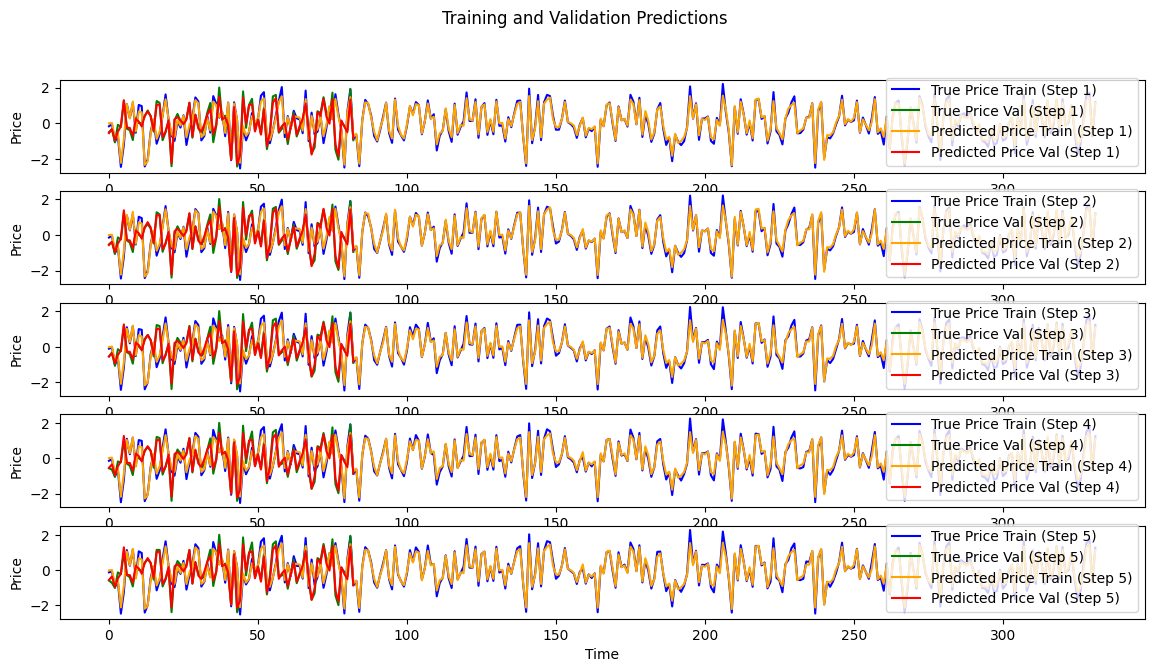

In [31]:
# 函数：可视化多步预测结果
def plot_predictions(y_train, y_val, y_pred_train, y_pred_val, title):
    plt.figure(figsize=(14, 7))  # 设置画布大小
    for step in range(output_steps):
        plt.subplot(output_steps, 1, step + 1)  # 为每个时间步绘制一个子图
        # 绘制训练集的真实价格
        plt.plot(np.arange(len(y_train[:, step])), y_train[:, step], label=f'True Price Train (Step {step+1})', color='blue')
        # 绘制验证集的真实价格
        plt.plot(np.arange(len(y_val[:, step])), y_val[:, step], label=f'True Price Val (Step {step+1})', color='green')
        # 绘制训练集的预测价格
        plt.plot(np.arange(len(y_pred_train[:, step])), y_pred_train[:, step], label=f'Predicted Price Train (Step {step+1})', color='orange')
        # 绘制验证集的预测价格
        plt.plot(np.arange(len(y_pred_val[:, step])), y_pred_val[:, step], label=f'Predicted Price Val (Step {step+1})', color='red')
        plt.xlabel('Time')  # 设置x轴标签
        plt.ylabel('Price')  # 设置y轴标签
        plt.legend()  # 显示图例
    plt.suptitle(title)  # 设置标题
    plt.show()

# 预测并绘制结果
y_pred_train = model.predict([X_price_train, X_sentiment_train])
y_pred_val = model.predict([X_price_val, X_sentiment_val])
plot_predictions(y_train, y_val, y_pred_train, y_pred_val, 'Training and Validation Predictions')


评估指标

在这里，我们计算了各种评估指标，如均方误差（MSE）、平均绝对误差（MAE）、均方根误差（RMSE）、决定系数（R2）、平均绝对百分比误差（MAPE）和对称平均绝对百分比误差（SMAPE）等，针对每个时间步进行计算，并对其进行平均，从而全面评估模型的性能。

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 计算模型性能的函数
def evaluate_model_performance(y_true, y_pred, output_steps):
    evaluation_results = []

    # 遍历每个时间步的预测结果
    for step in range(output_steps):
        # 计算每个时间步的评估指标
        mse = mean_squared_error(y_true[:, step], y_pred[:, step])  # 均方误差
        mae = mean_absolute_error(y_true[:, step], y_pred[:, step])  # 平均绝对误差
        rmse = np.sqrt(mse)  # 均方根误差
        r2 = r2_score(y_true[:, step], y_pred[:, step])  # R2得分
        mape = np.mean(np.abs((y_true[:, step] - y_pred[:, step]) / y_true[:, step])) * 100  # 平均绝对百分比误差
        smape = 100 * np.mean(2 * np.abs(y_true[:, step] - y_pred[:, step]) / (np.abs(y_true[:, step]) + np.abs(y_pred[:, step])))  # 对称平均绝对百分比误差

        # 将每个时间步的结果存入列表
        evaluation_results.append({
            'step': step + 1,  # 当前时间步
            'mse': mse,  # 均方误差
            'mae': mae,  # 平均绝对误差
            'rmse': rmse,  # 均方根误差
            'r2': r2,  # R2得分
            'mape': mape,  # 平均绝对百分比误差
            'smape': smape  # 对称平均绝对百分比误差
        })

    # 计算所有时间步的平均指标，并添加到结果中
    avg_results = {
        'step': 'avg',  # 平均值
        'mse': np.mean([result['mse'] for result in evaluation_results]),  # 平均均方误差
        'mae': np.mean([result['mae'] for result in evaluation_results]),  # 平均绝对误差
        'rmse': np.mean([result['rmse'] for result in evaluation_results]),  # 平均均方根误差
        'r2': np.mean([result['r2'] for result in evaluation_results]),  # 平均R2得分
        'mape': np.mean([result['mape'] for result in evaluation_results]),  # 平均绝对百分比误差
        'smape': np.mean([result['smape'] for result in evaluation_results])  # 平均对称平均绝对百分比误差
    }
    evaluation_results.append(avg_results)

    # 返回包含评估结果的DataFrame
    return pd.DataFrame(evaluation_results)

# 计算训练集和验证集的评估指标
train_eval_df = evaluate_model_performance(y_train, y_pred_train, output_steps)
val_eval_df = evaluate_model_performance(y_val, y_pred_val, output_steps)

# 打印训练集的评估结果
print("训练集评估结果:")
print(train_eval_df)

# 打印验证集的评估结果
print("验证集评估结果:")
print(val_eval_df)


训练集评估结果:
  step       mse       mae      rmse        r2        mape      smape
0    1  0.029018  0.131419  0.170347  0.970948   47.082545  29.769968
1    2  0.023214  0.116275  0.152361  0.976988  193.217371  27.429140
2    3  0.037176  0.147558  0.192812  0.963265   38.122677  30.238534
3    4  0.035590  0.144754  0.188654  0.964715   41.271795  31.944284
4    5  0.033750  0.137546  0.183713  0.966473   34.829199  28.978708
5  avg  0.031750  0.135510  0.177577  0.968478   70.904717  29.672127
验证集评估结果:
  step       mse       mae      rmse        r2        mape      smape
0    1  0.032233  0.134574  0.179536  0.967016   54.361303  34.676762
1    2  0.024891  0.120545  0.157769  0.974383   39.474270  30.465252
2    3  0.037801  0.146179  0.194426  0.960768   94.033578  33.004110
3    4  0.036489  0.144536  0.191020  0.961796  494.589062  36.011638
4    5  0.039371  0.149642  0.198422  0.959152   78.076590  35.762597
5  avg  0.034157  0.139095  0.184234  0.964623  152.106961  33.984071


绘制误差分布

为了更好地理解模型的误差，我们绘制了验证集的误差分布。这个可视化帮助识别预测中可能存在的显著偏差或不一致性。

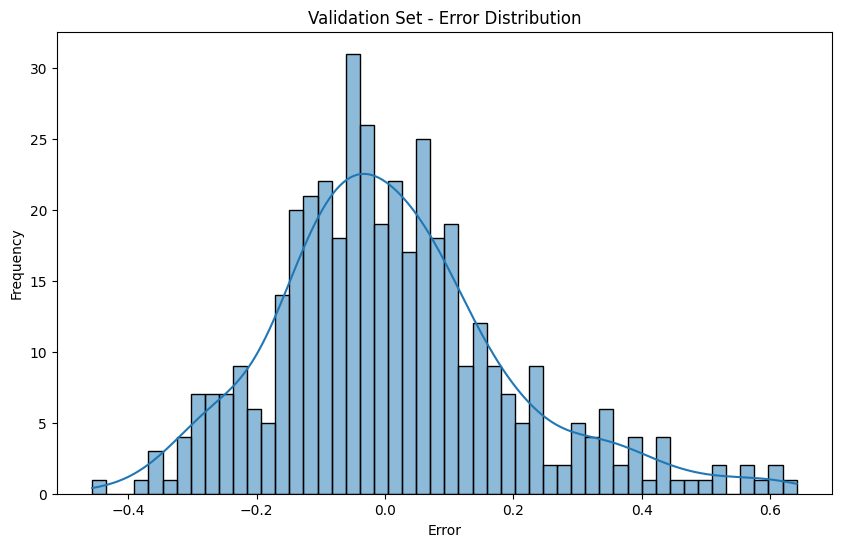

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制误差分布的函数
def plot_error_distribution(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    # 计算预测误差
    errors = y_true.flatten() - y_pred.flatten()
    # 使用seaborn绘制误差的直方图，并显示核密度估计（KDE）
    sns.histplot(errors, bins=50, kde=True)
    # 设置图表标题和标签
    plt.title(f'{title} - Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

# 绘制验证集的误差分布
plot_error_distribution(y_val, y_pred_val, 'Validation Set')


Attention Weights Visualization

如果模型使用了注意力机制，本节将提取并可视化注意力权重。理解注意力机制可以帮助我们洞察模型关注的时间步或特征。

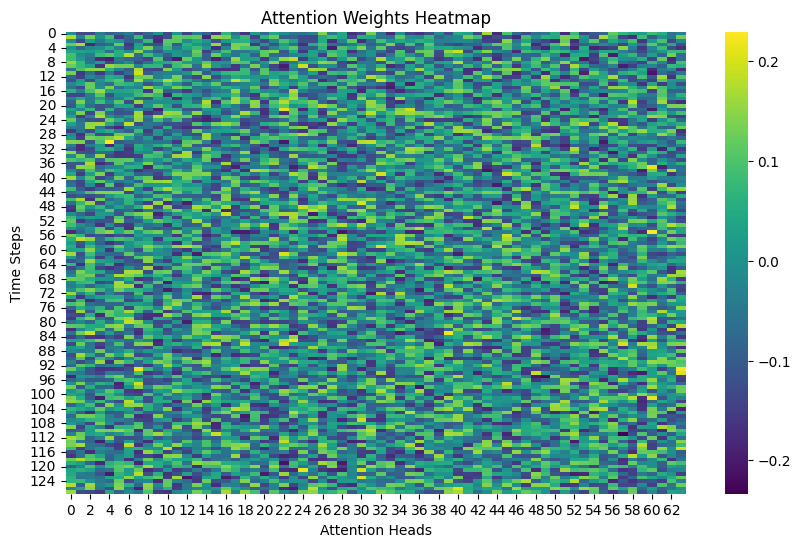

In [34]:
# 绘制注意力权重的函数
def plot_attention_weights(attention_weights, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights, cmap='viridis')  # 使用热图可视化注意力权重
    plt.title(title)  # 设置标题
    plt.xlabel('Attention Heads')  # 设置X轴标签
    plt.ylabel('Time Steps')  # 设置Y轴标签
    plt.show()  # 显示图形

# 提取并绘制注意力权重
attention_weights = model.layers[-3].get_weights()[0]  # 获取倒数第三层的注意力权重
plot_attention_weights(attention_weights, 'Attention Weights Heatmap')  # 绘制注意力权重热图


使用贝叶斯方法量化不确定性

本节通过生成多个预测并计算标准差，使用贝叶斯方法量化预测的不确定性。然后，将模型的不确定性与预测一起进行可视化。

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


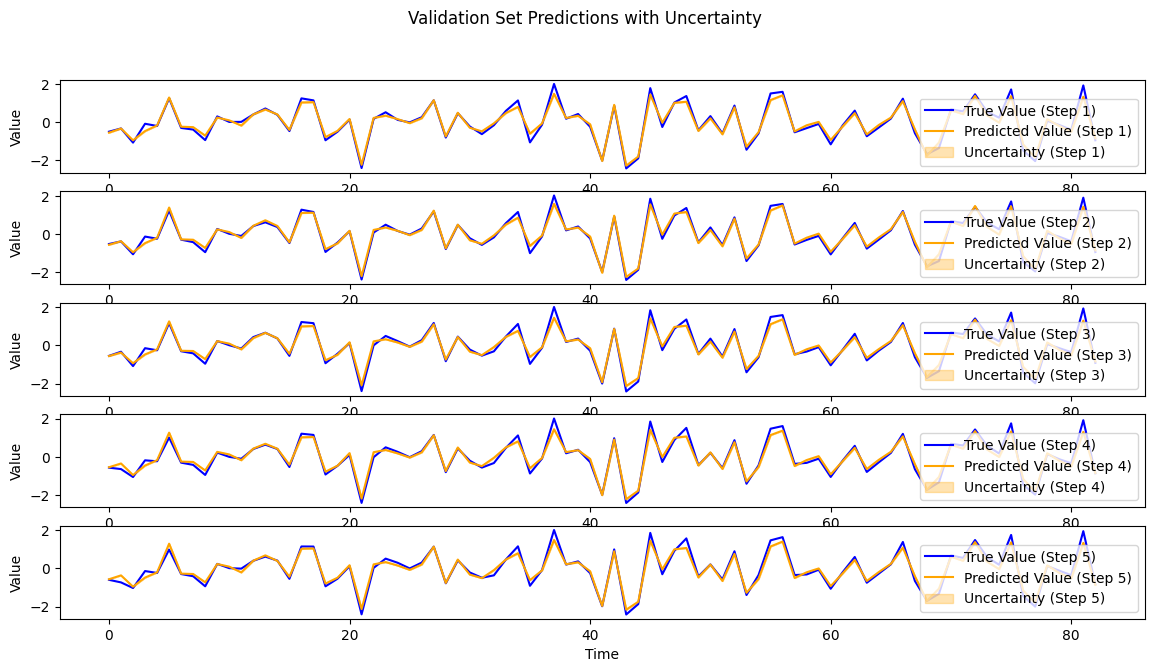

In [35]:
# 带不确定性量化的预测函数
def predict_with_uncertainty(model, X, n_iter=100):
    result = np.zeros((n_iter, X[0].shape[0], model.output.shape[1]))  # 初始化存储预测结果的数组
    for i in range(n_iter):
        result[i, :, :] = model.predict(X)  # 多次预测并存储结果
    prediction = result.mean(axis=0)  # 计算所有预测的平均值作为最终预测
    uncertainty = result.std(axis=0)  # 计算所有预测的标准差作为不确定性
    return prediction, uncertainty

# 带不确定性可视化的预测绘图函数
def plot_predictions_with_uncertainty(y_true, y_pred, uncertainty, title):
    plt.figure(figsize=(14, 7))  # 设置图像大小
    time_steps = np.arange(y_true.shape[0])  # 获取时间步序列
    for step in range(y_true.shape[1]):
        plt.subplot(y_true.shape[1], 1, step + 1)  # 根据预测步数绘制多个子图
        # 绘制真实值
        plt.plot(time_steps, y_true[:, step], label=f'True Value (Step {step+1})', color='blue')
        # 绘制预测值
        plt.plot(time_steps, y_pred[:, step], label=f'Predicted Value (Step {step+1})', color='orange')
        # 绘制不确定性带
        plt.fill_between(time_steps,
                         y_pred[:, step] - 2 * uncertainty[:, step],  # 预测值 - 2倍不确定性
                         y_pred[:, step] + 2 * uncertainty[:, step],  # 预测值 + 2倍不确定性
                         color='orange', alpha=0.3, label=f'Uncertainty (Step {step+1})')  # 绘制不确定性区域
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()  # 显示图例
    plt.suptitle(title)  # 设置标题
    plt.show()  # 显示图像

# 为训练集和验证集进行预测并计算不确定性
y_pred_train, train_uncertainty = predict_with_uncertainty(model, [X_price_train, X_sentiment_train])
y_pred_val, val_uncertainty = predict_with_uncertainty(model, [X_price_val, X_sentiment_val])

# 绘制验证集的预测结果和不确定性
plot_predictions_with_uncertainty(y_val, y_pred_val, val_uncertainty, 'Validation Set Predictions with Uncertainty')


时间序列数据的交叉验证

为了进一步验证模型的性能，本节通过使用时间序列分割进行交叉验证，确保模型在数据的不同子集上表现稳健。

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 时间序列数据的交叉验证函数
def cross_validate_model(model_fn, X_price, X_sentiment, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)  # 使用时间序列分割
    cv_results = []  # 存储交叉验证的结果
    for train_index, val_index in tscv.split(X_price):
        # 划分训练集和验证集
        X_price_train, X_price_val = X_price[train_index], X_price[val_index]
        X_sentiment_train, X_sentiment_val = X_sentiment[train_index], X_sentiment[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # 使用提供的模型函数初始化模型
        model = model_fn(price_input_shape, sentiment_input_shape, output_steps)

        # 训练模型
        model.fit([X_price_train, X_sentiment_train], y_train, validation_data=([X_price_val, X_sentiment_val], y_val),
                  epochs=50, batch_size=32, callbacks=callbacks)

        # 预测验证集并计算评估指标
        y_pred_val = model.predict([X_price_val, X_sentiment_val])
        val_mse = mean_squared_error(y_val, y_pred_val)
        val_mae = mean_absolute_error(y_val, y_pred_val)

        # 保存验证集结果
        cv_results.append((val_mse, val_mae))

    return cv_results

# 执行交叉验证
cv_results = cross_validate_model(fusion_model_multi_step, X_price, X_sentiment, y, n_splits=5)

# 输出交叉验证结果
print("Cross-validation results:", cv_results)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 2.4491 - mae: 1.6778 - val_loss: 0.9603 - val_mae: 1.1648 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.6078 - mae: 1.3983 - val_loss: 1.6056 - val_mae: 1.5567 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.2575 - mae: 1.2303 - val_loss: 1.8033 - val_mae: 1.6788 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.1756 - mae: 1.1715 - val_loss: 1.6535 - val_mae: 1.6387 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.9354 - mae: 1.0662 - val_loss: 1.4076 - val_mae: 1.5359 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.8346 - mae: 0.9802 - val_loss: 1.1607 - val_mae: 1.4191 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.8753 - mae: 1.0278 - val_loss: 1.1022 - val_mae: 1.3909 - learning_rate: 1.0000e-04
Epoch 8/50
3/3 ━━━